# Generador de rostros artificiales mediante redes adversativas

Se modifica el entrenamiento para entrenar mas al discriminador o al generador segun convenga. Se va a utilizar el dataset2

En una red adversaria se tienen dos modelos (que pueden ser Redes Neuronales o Convolucionales) compitiendo: un Generador y un Discriminador.

Se genera un primer modelo que llamaremos Discriminador para que sea capaz de reconocer rostros humanos. Este discriminador será simplemente un clasificador,que buscara indicar si una imagen es real o falsa

Se genera un segundo modelo, que llamaremos Generador y nuestro objetivo es entrenarlo para que sea capaz de tomar una entrada aleatoria y a la salida generar algo muy parecido a una imagen de un rostro.

La idea es entrenar esos dos modelos simultáneamente buscando que al final sea el Generador el vencedor en esta competencia.

## Funciones y carga de datos

In [2]:
TAM_ENTRADA = 100 # vector de entrada del modelo
TAM_IMG = 32 # tamaño de la imagen

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Funcion para carga y visualizar datos

In [4]:
def cargar_datos(dataset):
    print('Creando set de entrenamiento...')
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,TAM_IMG,TAM_IMG,3))

    for i in range(n_imgs):
        direcion = str(dataset)+ "\\" + str(filelist[i])
        imagen = cv2.imread(direcion,1)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        imagen = cv2.resize(imagen, dsize=(TAM_IMG, TAM_IMG))
        imagen = (imagen - 127.5)/127.5 #para dejarlo entre -1 y 1
        x_train[i,:] = imagen
    print('¡Listo!')

    return x_train

def visualizar_imagen(imagen):
    imagen = imagen * 0.5 + 0.5 #para pasarlo de 0 a 1
    plt.imshow(imagen)
    plt.show()


In [5]:
def visualizarMosaico(GAN, w= 3, h=3):
    
    fig, axs = plt.subplots(w,h,figsize=(h*2,w*2))
    
    for i in range(w):
        for j in range(h):
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            imagen = GAN.layers[0].predict(ruido)
            imagen = imagen * 0.5 + 0.5
            imagen = imagen.reshape(TAM_IMG, TAM_IMG, 3)
            axs[i][j].imshow(imagen)
            

### Funciones para crear el modelo

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, UpSampling2D, Dropout
import tensorflow.keras.optimizers as optimizador
import time
import seaborn as sns

In [7]:
def crear_generador():
    modelo = Sequential(name = "Generador")
    
    modelo.add(Dense(int(TAM_IMG/8)*int(TAM_IMG/8)*256, use_bias=False, input_shape=(TAM_ENTRADA,)))
    
    modelo.add(Reshape((int(TAM_IMG/8), int(TAM_IMG/8),256))) #512
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 4x4x512

    modelo.add(Conv2DTranspose(128, 3, strides = 2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 8x8x256

    modelo.add(Conv2DTranspose(64, 5, strides = 2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 16x16x128
 
    modelo.add(Conv2DTranspose(3, 5, strides = 2, activation = 'tanh', padding='same', use_bias=False))
    #Tamaño resultante: 32x32x3
    
    print("Generador Creado")
    return modelo


In [8]:
def crear_discriminador(optimizador, error):
    
    modelo = Sequential(name = "Discriminador")

    modelo.add(Conv2D(32, 5, strides=1, padding='same', use_bias=False, input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #32x32x32
    
    modelo.add(Conv2D(64, 5, strides=2, padding='same', use_bias=False, input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #16x16x64

    modelo.add(Conv2D(128, 5, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #8x8x128
    
    modelo.add(Conv2D(256, 5, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #4x4x256
    
    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer = optimizador, loss= error)

    print("Discriminador Creado")
    return modelo

In [9]:
def crear_GAN(optimizador_g, error_g, optimizador_d=None, error_d=None):
    
    if optimizador_d==None:
        optimizador_d = optimizador_g
    
    if error_d==None:
        error_d = error_g
        
    generador = crear_generador()
    discriminador = crear_discriminador(optimizador_d, error_d)
    
    modelo = Sequential(name = "GAN")
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    
    modelo.compile(optimizer = optimizador_g, loss= error_g)

    print("GAN Creado")
    return modelo


In [10]:
def predicion(GAN, ruido):
    print(GAN(ruido))  
    imagen = GAN.layers[0].predict(ruido)
    visualizar_imagen(imagen.reshape(TAM_IMG, TAM_IMG, 3))

### Funciones para el entrenamiento

En el caso de las Redes Adversarias debemos llevar a cabo estos pasos:

1. “Descongelar” los coeficientes del Discriminador
2. Entrenar solo el Discriminador con imagenes falsas y reales
3. “Congelar” los coeficientes del Discriminador
4. Entrenar la GAN, al estar congelado el discriminador únicamente se entrenara el Generador
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar el entrenamiento

In [35]:
 def entrenar(GAN, ITERACIONES, TAM_LOTE, CARPETAGUARDADO, GUARDAR_IMG = 100):
    
    generador = GAN.layers[0]
    discriminador = GAN.layers[1]
    entrenado = np.array([]) #aca se guarda que se entreno 1 para discrimiando, 0 para generador
    prediccion_falsa = np.array([])
    
    for i in range(1, ITERACIONES+1):
        start = time.time()
        print("Comenzando Epoca " + str(i) + ". ", end = "")
        
        # promedio el resultado de 10 randos

        ruido = np.random.normal(0, 1, [10, TAM_ENTRADA]) 
        resultado = GAN(ruido)
        resultado = np.mean(resultado)
        
        if resultado >= 0.5:
            print("Entrenenamos Discriminador", end = "")
            # Crear un "batch" de imágenes falsas y otro con imágenes reales
            ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
            batch_falsas = generador.predict(ruido)

            idx = np.random.randint(low=0, high=x_train.shape[0], size= TAM_LOTE)
            batch_reales = x_train[idx]

            #la unificacion del batch de entrenamiento es lo que logra que el modelo aprenda
            batch = np.concatenate((batch_reales, batch_falsas))

            #las reales le digo como resultado 1 con np.ones (el 0.9 ayuda a que converga mejor)
            #las falsas le digo como resultado 0 con np.zeros
            valores = np.concatenate((np.ones(TAM_LOTE)*0.9, np.zeros(TAM_LOTE)))

            print(".", end = "")

            discriminador.trainable = True

            # Entrenar discriminador con imagener falsas y reales
            dError = discriminador.train_on_batch(batch, valores)

            entrenado = np.append(entrenado, 1)

            #congelo el discriminador
            discriminador.trainable = False

            print(".", end = "")
            
        else:
            print("Entrenenamos Generador", end = "")

            # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN como si fuesen imagenes reales
            ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
            gError = GAN.train_on_batch(ruido, np.ones(TAM_LOTE))

            entrenado = np.append(entrenado, 0)

            print(".", end = "")

        #Cada 100 iteraciones vamos a guardar una imagen
        if i==1 or i%GUARDAR_IMG == 0:
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            resultado = generador.predict(ruido)
            resultado = resultado * 0.5 + 0.5
            plt.imshow(resultado.reshape(TAM_IMG, TAM_IMG, 3))
            plt.savefig(CARPETAGUARDADO + "/r" + str(i) + ".png")

        #hacemos una prueba de prediccion
        ruido = np.random.normal(0, 1, TAM_ENTRADA)
        ruido = np.array([ruido])
        resultado = GAN.predict(ruido)

        prediccion_falsa = np.append(prediccion_falsa, resultado)
        end = time.time()
        print(" Fin")
        print("Tiempo transcurrido: ", round((end - start), 2), "s")
        trm = (ITERACIONES + 1 - i) * (end - start) / 60 #tiempo restante en minutos
        print("Tiempo restante aprox: " + str(round(trm, 2)) + "m -> " + str(int(trm/60)) + ":" + str(int(trm%60)) + "h")
        print("prediccion de ruido: ", resultado)
        print("===================================================================")
     
    return entrenado, prediccion_falsa
            
def plot_acumulado(tamaño, lim_sup = 1, **valores):
    t = np.linspace(1, tamaño, tamaño)
    plt.figure(figsize=(20, 6))
    plt.ylim(0, lim_sup)
    for v in valores:
        sns.lineplot(x=t, y=valores[v], label=v)


## Carga de datos

In [12]:
x_train = cargar_datos("dataset2/data_tratada/")

Creando set de entrenamiento...
¡Listo!


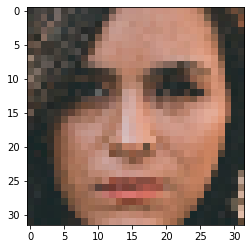

In [17]:
visualizar_imagen(x_train[1597])

## Prueba de modelos

### Primer prueba

In [18]:
OPTIMIZADOR1 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR1 = 'binary_crossentropy' 

gan1 = crear_GAN(OPTIMIZADOR1, ERROR1)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1. Entrenenamos Generador. Fin
Tiempo transcurrido:  2.33 s
Tiempo restante aprox: 116.55m -> 1:56h
prediccion de ruido:  [[0.50028896]]
Comenzando Epoca 2. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.32 s
Tiempo restante aprox: 115.96m -> 1:55h
prediccion de ruido:  [[0.4996932]]
Comenzando Epoca 3. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 45.0m -> 0:45h
prediccion de ruido:  [[0.50008494]]
Comenzando Epoca 4. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 85.79m -> 1:25h
prediccion de ruido:  [[0.4956299]]
Comenzando Epoca 5. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 45.39m -> 0:45h
prediccion de ruido:  [[0.49748302]]
Comenzando Epoca 6. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 45.84m -> 0:45h
prediccion de ruido:  [[0.49794057]]
Comenzando Epoca 7. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92

Comenzando Epoca 38. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 45.41m -> 0:45h
prediccion de ruido:  [[0.5002519]]
Comenzando Epoca 39. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 44.51m -> 0:44h
prediccion de ruido:  [[0.49716824]]
Comenzando Epoca 40. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 45.41m -> 0:45h
prediccion de ruido:  [[0.5029223]]
Comenzando Epoca 41. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 84.72m -> 1:24h
prediccion de ruido:  [[0.48771912]]
Comenzando Epoca 42. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 44.81m -> 0:44h
prediccion de ruido:  [[0.4876904]]
Comenzando Epoca 43. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 45.96m -> 0:45h
prediccion de ruido:  [[0.4936348]]
Comenzando Epoca 44. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 

Comenzando Epoca 75. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 44.13m -> 0:44h
prediccion de ruido:  [[0.50463146]]
Comenzando Epoca 76. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 83.75m -> 1:23h
prediccion de ruido:  [[0.46960393]]
Comenzando Epoca 77. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 44.23m -> 0:44h
prediccion de ruido:  [[0.47544336]]
Comenzando Epoca 78. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 44.8m -> 0:44h
prediccion de ruido:  [[0.4825934]]
Comenzando Epoca 79. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 43.98m -> 0:43h
prediccion de ruido:  [[0.49220356]]
Comenzando Epoca 80. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 44.77m -> 0:44h
prediccion de ruido:  [[0.5059806]]
Comenzando Epoca 81. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92

Comenzando Epoca 112. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 45.01m -> 0:45h
prediccion de ruido:  [[0.3853302]]
Comenzando Epoca 113. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 43.98m -> 0:43h
prediccion de ruido:  [[0.40587097]]
Comenzando Epoca 114. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 48.26m -> 0:48h
prediccion de ruido:  [[0.4269727]]
Comenzando Epoca 115. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 47.69m -> 0:47h
prediccion de ruido:  [[0.44145918]]
Comenzando Epoca 116. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 48.08m -> 0:48h
prediccion de ruido:  [[0.4569657]]
Comenzando Epoca 117. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 43.95m -> 0:43h
prediccion de ruido:  [[0.47174382]]
Comenzando Epoca 118. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9

Comenzando Epoca 149. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 82.64m -> 1:22h
prediccion de ruido:  [[0.48538283]]
Comenzando Epoca 150. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 43.62m -> 0:43h
prediccion de ruido:  [[0.5371065]]
Comenzando Epoca 151. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 83.6m -> 1:23h
prediccion de ruido:  [[0.50053585]]
Comenzando Epoca 152. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 82.05m -> 1:22h
prediccion de ruido:  [[0.45576873]]
Comenzando Epoca 153. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 43.25m -> 0:43h
prediccion de ruido:  [[0.5147126]]
Comenzando Epoca 154. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.83 s
Tiempo restante aprox: 87.07m -> 1:27h
prediccion de ruido:  [[0.47751778]]
Comenzando Epoca 155. Entrenenamos Generador. Fin
Tie

Comenzando Epoca 186. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.88 s
Tiempo restante aprox: 88.31m -> 1:28h
prediccion de ruido:  [[0.34397775]]
Comenzando Epoca 187. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 44.62m -> 0:44h
prediccion de ruido:  [[0.42965382]]
Comenzando Epoca 188. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 43.2m -> 0:43h
prediccion de ruido:  [[0.4159577]]
Comenzando Epoca 189. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 42.87m -> 0:42h
prediccion de ruido:  [[0.4866068]]
Comenzando Epoca 190. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 43.0m -> 0:42h
prediccion de ruido:  [[0.47118628]]
Comenzando Epoca 191. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 42.55m -> 0:42h
prediccion de ruido:  [[0.52748376]]
Comenzando Epoca 192. Entrenenamos Discriminador.. Fin
Tiempo transcu

Comenzando Epoca 223. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 41.89m -> 0:41h
prediccion de ruido:  [[0.20875207]]
Comenzando Epoca 224. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 41.88m -> 0:41h
prediccion de ruido:  [[0.84553504]]
Comenzando Epoca 225. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 79.39m -> 1:19h
prediccion de ruido:  [[0.31860495]]
Comenzando Epoca 226. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 41.85m -> 0:41h
prediccion de ruido:  [[0.31091583]]
Comenzando Epoca 227. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 42.55m -> 0:42h
prediccion de ruido:  [[0.1972898]]
Comenzando Epoca 228. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 43.26m -> 0:43h
prediccion de ruido:  [[0.6392605]]
Comenzando Epoca 229. Entrenenamos Discriminador.. Fin
Tiempo transcur

Comenzando Epoca 260. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 44.19m -> 0:44h
prediccion de ruido:  [[0.24766335]]
Comenzando Epoca 261. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 42.03m -> 0:42h
prediccion de ruido:  [[0.68130475]]
Comenzando Epoca 262. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 79.05m -> 1:19h
prediccion de ruido:  [[0.70374495]]
Comenzando Epoca 263. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 42.0m -> 0:42h
prediccion de ruido:  [[0.5370698]]
Comenzando Epoca 264. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 41.27m -> 0:41h
prediccion de ruido:  [[0.7088804]]
Comenzando Epoca 265. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 41.97m -> 0:41h
prediccion de ruido:  [[0.6455016]]
Comenzando Epoca 266. Entrenenamos Discriminador.. Fin
Tiempo transcur

Comenzando Epoca 297. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 42.32m -> 0:42h
prediccion de ruido:  [[0.5089517]]
Comenzando Epoca 298. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.8 s
Tiempo restante aprox: 81.27m -> 1:21h
prediccion de ruido:  [[0.412319]]
Comenzando Epoca 299. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.81 s
Tiempo restante aprox: 81.48m -> 1:21h
prediccion de ruido:  [[0.553237]]
Comenzando Epoca 300. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 46.4m -> 0:46h
prediccion de ruido:  [[0.45022276]]
Comenzando Epoca 301. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 40.76m -> 0:40h
prediccion de ruido:  [[0.6045587]]
Comenzando Epoca 302. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 78.91m -> 1:18h
prediccion de ruido:  [[0.48868477]]
Comenzando Epoca 303. Entrenenamos Discriminador.. Fin
Tiempo t

Comenzando Epoca 334. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.01 s
Tiempo restante aprox: 89.49m -> 1:29h
prediccion de ruido:  [[0.69881076]]
Comenzando Epoca 335. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.0 s
Tiempo restante aprox: 88.7m -> 1:28h
prediccion de ruido:  [[0.7369134]]
Comenzando Epoca 336. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.05 s
Tiempo restante aprox: 91.2m -> 1:31h
prediccion de ruido:  [[0.69168013]]
Comenzando Epoca 337. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.01 s
Tiempo restante aprox: 89.03m -> 1:29h
prediccion de ruido:  [[0.46564972]]
Comenzando Epoca 338. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 46.3m -> 0:46h
prediccion de ruido:  [[0.6137601]]
Comenzando Epoca 339. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.02 s
Tiempo restante aprox: 89.81m -> 1:29h
prediccion de ruido:  [[0.7238595]]
Comenzando Epoca 340. Entrenenamos Discriminador.. F

Comenzando Epoca 371. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.96 s
Tiempo restante aprox: 86.1m -> 1:26h
prediccion de ruido:  [[0.5868423]]
Comenzando Epoca 372. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.97 s
Tiempo restante aprox: 86.2m -> 1:26h
prediccion de ruido:  [[0.44018784]]
Comenzando Epoca 373. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 45.78m -> 0:45h
prediccion de ruido:  [[0.7785673]]
Comenzando Epoca 374. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.98 s
Tiempo restante aprox: 86.83m -> 1:26h
prediccion de ruido:  [[0.64963937]]
Comenzando Epoca 375. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.99 s
Tiempo restante aprox: 87.06m -> 1:27h
prediccion de ruido:  [[0.51850224]]
Comenzando Epoca 376. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.02 s
Tiempo restante aprox: 88.17m -> 1:28h
prediccion de ruido:  [[0.64256746]]
Comenzando Epoca 377. Entrenenamos Discriminador.

Comenzando Epoca 443. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 72.47m -> 1:12h
prediccion de ruido:  [[0.61364746]]
Comenzando Epoca 444. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 39.22m -> 0:39h
prediccion de ruido:  [[0.8113611]]
Comenzando Epoca 445. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 72.52m -> 1:12h
prediccion de ruido:  [[0.69397926]]
Comenzando Epoca 446. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.92 s
Tiempo restante aprox: 81.71m -> 1:21h
prediccion de ruido:  [[0.7204232]]
Comenzando Epoca 447. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 72.38m -> 1:12h
prediccion de ruido:  [[0.6375911]]
Comenzando Epoca 448. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 72.35m -> 1:12h
prediccion de ruido:  [[0.5343958]]
Comenzando Epoca 449. Entrenenamos Discriminador.. Fi

Comenzando Epoca 480. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 38.02m -> 0:38h
prediccion de ruido:  [[0.6911228]]
Comenzando Epoca 481. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 71.42m -> 1:11h
prediccion de ruido:  [[0.41151032]]
Comenzando Epoca 482. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 71.39m -> 1:11h
prediccion de ruido:  [[0.6388006]]
Comenzando Epoca 483. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 72.02m -> 1:12h
prediccion de ruido:  [[0.45134997]]
Comenzando Epoca 484. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 37.96m -> 0:37h
prediccion de ruido:  [[0.54237884]]
Comenzando Epoca 485. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 71.3m -> 1:11h
prediccion de ruido:  [[0.4626088]]
Comenzando Epoca 486. Entrenenamos Discriminador.. Fin
Tiem

Comenzando Epoca 517. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 70.4m -> 1:10h
prediccion de ruido:  [[0.6948912]]
Comenzando Epoca 518. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 70.37m -> 1:10h
prediccion de ruido:  [[0.62123567]]
Comenzando Epoca 519. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 37.43m -> 0:37h
prediccion de ruido:  [[0.42735174]]
Comenzando Epoca 520. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 70.39m -> 1:10h
prediccion de ruido:  [[0.6648831]]
Comenzando Epoca 521. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 70.37m -> 1:10h
prediccion de ruido:  [[0.36262438]]
Comenzando Epoca 522. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 70.98m -> 1:10h
prediccion de ruido:  [[0.46695843]]
Comenzando Epoca 523. Entrenenamos Generador. Fin
Tie

Comenzando Epoca 554. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 36.9m -> 0:36h
prediccion de ruido:  [[0.718048]]
Comenzando Epoca 555. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 71.59m -> 1:11h
prediccion de ruido:  [[0.80302227]]
Comenzando Epoca 556. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 69.29m -> 1:9h
prediccion de ruido:  [[0.63414395]]
Comenzando Epoca 557. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 69.26m -> 1:9h
prediccion de ruido:  [[0.7270229]]
Comenzando Epoca 558. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 69.91m -> 1:9h
prediccion de ruido:  [[0.5138497]]
Comenzando Epoca 559. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 69.21m -> 1:9h
prediccion de ruido:  [[0.5318858]]
Comenzando Epoca 560. Entrenenamos Discriminador.. Fin
Tiem

Comenzando Epoca 591. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 68.3m -> 1:8h
prediccion de ruido:  [[0.66189617]]
Comenzando Epoca 592. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 68.27m -> 1:8h
prediccion de ruido:  [[0.62536037]]
Comenzando Epoca 593. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 68.87m -> 1:8h
prediccion de ruido:  [[0.5795636]]
Comenzando Epoca 594. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 68.21m -> 1:8h
prediccion de ruido:  [[0.5444685]]
Comenzando Epoca 595. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 68.19m -> 1:8h
prediccion de ruido:  [[0.5079663]]
Comenzando Epoca 596. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.68 s
Tiempo restante aprox: 67.53m -> 1:7h
prediccion de ruido:  [[0.46304965]]
Comenzando Epoca 597. Entrenenamos Discriminador.. Fin

Comenzando Epoca 628. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 67.91m -> 1:7h
prediccion de ruido:  [[0.59983194]]
Comenzando Epoca 629. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 68.46m -> 1:8h
prediccion de ruido:  [[0.37136957]]
Comenzando Epoca 630. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 35.75m -> 0:35h
prediccion de ruido:  [[0.6483817]]
Comenzando Epoca 631. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 67.78m -> 1:7h
prediccion de ruido:  [[0.45843908]]
Comenzando Epoca 632. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 67.14m -> 1:7h
prediccion de ruido:  [[0.5355982]]
Comenzando Epoca 633. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 35.71m -> 0:35h
prediccion de ruido:  [[0.7033426]]
Comenzando Epoca 634. Entrenenamos Discriminador.. Fin
Tiemp

Comenzando Epoca 665. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 66.2m -> 1:6h
prediccion de ruido:  [[0.5634577]]
Comenzando Epoca 666. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 66.17m -> 1:6h
prediccion de ruido:  [[0.64915204]]
Comenzando Epoca 667. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 66.15m -> 1:6h
prediccion de ruido:  [[0.48812273]]
Comenzando Epoca 668. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 66.12m -> 1:6h
prediccion de ruido:  [[0.586071]]
Comenzando Epoca 669. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 35.17m -> 0:35h
prediccion de ruido:  [[0.68560404]]
Comenzando Epoca 670. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 66.06m -> 1:6h
prediccion de ruido:  [[0.5444216]]
Comenzando Epoca 671. Entrenenamos Discriminador.. Fin
Tiempo

Comenzando Epoca 702. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 33.83m -> 0:33h
prediccion de ruido:  [[0.7323653]]
Comenzando Epoca 703. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.82 s
Tiempo restante aprox: 69.8m -> 1:9h
prediccion de ruido:  [[0.46290678]]
Comenzando Epoca 704. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.78 s
Tiempo restante aprox: 68.11m -> 1:8h
prediccion de ruido:  [[0.21381664]]
Comenzando Epoca 705. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 36.76m -> 0:36h
prediccion de ruido:  [[0.537196]]
Comenzando Epoca 706. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 37.65m -> 0:37h
prediccion de ruido:  [[0.46536392]]
Comenzando Epoca 707. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 35.47m -> 0:35h
prediccion de ruido:  [[0.55742204]]
Comenzando Epoca 708. Entrenenamos Discriminador.. Fin
Tiempo tran

Comenzando Epoca 739. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 64.91m -> 1:4h
prediccion de ruido:  [[0.56901073]]
Comenzando Epoca 740. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 64.78m -> 1:4h
prediccion de ruido:  [[0.7089642]]
Comenzando Epoca 741. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.69 s
Tiempo restante aprox: 63.69m -> 1:3h
prediccion de ruido:  [[0.34606183]]
Comenzando Epoca 742. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 33.55m -> 0:33h
prediccion de ruido:  [[0.5923053]]
Comenzando Epoca 743. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.77 s
Tiempo restante aprox: 66.51m -> 1:6h
prediccion de ruido:  [[0.5278065]]
Comenzando Epoca 744. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 34.73m -> 0:34h
prediccion de ruido:  [[0.6409499]]
Comenzando Epoca 745. Entrenenamos Discriminador.. Fin
Tie

Comenzando Epoca 776. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 64.33m -> 1:4h
prediccion de ruido:  [[0.5879872]]
Comenzando Epoca 777. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 63.27m -> 1:3h
prediccion de ruido:  [[0.51791805]]
Comenzando Epoca 778. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 63.17m -> 1:3h
prediccion de ruido:  [[0.35189912]]
Comenzando Epoca 779. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 33.61m -> 0:33h
prediccion de ruido:  [[0.487378]]
Comenzando Epoca 780. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 64.21m -> 1:4h
prediccion de ruido:  [[0.7580886]]
Comenzando Epoca 781. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 63.18m -> 1:3h
prediccion de ruido:  [[0.30511063]]
Comenzando Epoca 782. Entrenenamos Generador. Fin
Tiem

Comenzando Epoca 813. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 37.13m -> 0:37h
prediccion de ruido:  [[0.44452864]]
Comenzando Epoca 814. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.98 s
Tiempo restante aprox: 72.11m -> 1:12h
prediccion de ruido:  [[0.5431273]]
Comenzando Epoca 815. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 37.31m -> 0:37h
prediccion de ruido:  [[0.4970779]]
Comenzando Epoca 816. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.94 s
Tiempo restante aprox: 70.51m -> 1:10h
prediccion de ruido:  [[0.6417315]]
Comenzando Epoca 817. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.96 s
Tiempo restante aprox: 71.21m -> 1:11h
prediccion de ruido:  [[0.57848835]]
Comenzando Epoca 818. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 37.37m -> 0:37h
prediccion de ruido:  [[0.5592323]]
Comenzando Epoca 819. Entrenenamos Discriminador.. Fin
Tiem

Comenzando Epoca 850. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 33.06m -> 0:33h
prediccion de ruido:  [[0.00164488]]
Comenzando Epoca 851. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 33.18m -> 0:33h
prediccion de ruido:  [[0.10784295]]
Comenzando Epoca 852. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 32.7m -> 0:32h
prediccion de ruido:  [[0.57152337]]
Comenzando Epoca 853. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.79 s
Tiempo restante aprox: 64.02m -> 1:4h
prediccion de ruido:  [[0.2555889]]
Comenzando Epoca 854. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.79 s
Tiempo restante aprox: 64.22m -> 1:4h
prediccion de ruido:  [[0.07778305]]
Comenzando Epoca 855. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 33.66m -> 0:33h
prediccion de ruido:  [[0.01242033]]
Comenzando Epoca 856. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 887. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 59.91m -> 0:59h
prediccion de ruido:  [[0.6587684]]
Comenzando Epoca 888. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 61.05m -> 1:1h
prediccion de ruido:  [[0.8109331]]
Comenzando Epoca 889. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.8 s
Tiempo restante aprox: 63.22m -> 1:3h
prediccion de ruido:  [[0.6526382]]
Comenzando Epoca 890. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 62.02m -> 1:2h
prediccion de ruido:  [[0.48608145]]
Comenzando Epoca 891. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 59.8m -> 0:59h
prediccion de ruido:  [[0.16513118]]
Comenzando Epoca 892. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 31.8m -> 0:31h
prediccion de ruido:  [[0.85934913]]
Comenzando Epoca 893. Entrenenamos Discriminador.. Fin
Ti

Comenzando Epoca 924. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 61.02m -> 1:1h
prediccion de ruido:  [[0.16480485]]
Comenzando Epoca 925. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 32.72m -> 0:32h
prediccion de ruido:  [[0.93613017]]
Comenzando Epoca 926. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.84 s
Tiempo restante aprox: 63.67m -> 1:3h
prediccion de ruido:  [[0.45198616]]
Comenzando Epoca 927. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 91.13m -> 1:31h
prediccion de ruido:  [[0.20627221]]
Comenzando Epoca 928. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 37.08m -> 0:37h
prediccion de ruido:  [[0.8934171]]
Comenzando Epoca 929. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.3 s
Tiempo restante aprox: 79.43m -> 1:19h
prediccion de ruido:  [[0.05604199]]
Comenzando Epoca 930. Entrenenamos Generador. Fin
Tiem

Comenzando Epoca 961. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 30.76m -> 0:30h
prediccion de ruido:  [[0.01056981]]
Comenzando Epoca 962. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 30.78m -> 0:30h
prediccion de ruido:  [[0.01522309]]
Comenzando Epoca 963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 31.26m -> 0:31h
prediccion de ruido:  [[2.3471888e-05]]
Comenzando Epoca 964. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 30.72m -> 0:30h
prediccion de ruido:  [[0.41844913]]
Comenzando Epoca 965. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 30.7m -> 0:30h
prediccion de ruido:  [[0.09910774]]
Comenzando Epoca 966. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 30.69m -> 0:30h
prediccion de ruido:  [[0.3002138]]
Comenzando Epoca 967. Entrenenamos Generador. Fin
Tiempo transcurrido:  0

Comenzando Epoca 998. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 30.35m -> 0:30h
prediccion de ruido:  [[0.3805034]]
Comenzando Epoca 999. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.77 s
Tiempo restante aprox: 59.06m -> 0:59h
prediccion de ruido:  [[0.31065327]]
Comenzando Epoca 1000. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.86 s
Tiempo restante aprox: 62.12m -> 1:2h
prediccion de ruido:  [[0.2775401]]
Comenzando Epoca 1001. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 32.31m -> 0:32h
prediccion de ruido:  [[0.4900485]]
Comenzando Epoca 1002. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 58.75m -> 0:58h
prediccion de ruido:  [[0.39314175]]
Comenzando Epoca 1003. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 32.96m -> 0:32h
prediccion de ruido:  [[0.6295964]]
Comenzando Epoca 1004. Entrenenamos Discriminador.. Fin


Comenzando Epoca 1035. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 32.48m -> 0:32h
prediccion de ruido:  [[0.5066469]]
Comenzando Epoca 1036. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 30.14m -> 0:30h
prediccion de ruido:  [[0.37890637]]
Comenzando Epoca 1037. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 30.17m -> 0:30h
prediccion de ruido:  [[0.6681813]]
Comenzando Epoca 1038. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 32.07m -> 0:32h
prediccion de ruido:  [[0.5065811]]
Comenzando Epoca 1039. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.19 s
Tiempo restante aprox: 71.55m -> 1:11h
prediccion de ruido:  [[0.00156286]]
Comenzando Epoca 1040. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 31.73m -> 0:31h
prediccion de ruido:  [[0.01256329]]
Comenzando Epoca 1041. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1072. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 34.98m -> 0:34h
prediccion de ruido:  [[0.19010377]]
Comenzando Epoca 1073. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 33.9m -> 0:33h
prediccion de ruido:  [[0.1222955]]
Comenzando Epoca 1074. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 30.09m -> 0:30h
prediccion de ruido:  [[0.59349453]]
Comenzando Epoca 1075. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 30.05m -> 0:30h
prediccion de ruido:  [[0.4660154]]
Comenzando Epoca 1076. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 32.12m -> 0:32h
prediccion de ruido:  [[0.37578374]]
Comenzando Epoca 1077. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.25 s
Tiempo restante aprox: 39.99m -> 0:39h
prediccion de ruido:  [[0.2804723]]
Comenzando Epoca 1078. Entrenenamos Generador. Fin
Tiempo transcurrid

Comenzando Epoca 1109. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 30.5m -> 0:30h
prediccion de ruido:  [[0.859509]]
Comenzando Epoca 1110. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 31.47m -> 0:31h
prediccion de ruido:  [[0.04998291]]
Comenzando Epoca 1111. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.99m -> 0:28h
prediccion de ruido:  [[0.03457505]]
Comenzando Epoca 1112. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.98m -> 0:28h
prediccion de ruido:  [[0.54376185]]
Comenzando Epoca 1113. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 54.0m -> 0:53h
prediccion de ruido:  [[0.22742748]]
Comenzando Epoca 1114. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.95m -> 0:28h
prediccion de ruido:  [[0.21834576]]
Comenzando Epoca 1115. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 1146. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 29.16m -> 0:29h
prediccion de ruido:  [[0.857611]]
Comenzando Epoca 1147. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 29.37m -> 0:29h
prediccion de ruido:  [[0.90726256]]
Comenzando Epoca 1148. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 29.17m -> 0:29h
prediccion de ruido:  [[0.03268489]]
Comenzando Epoca 1149. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 29.42m -> 0:29h
prediccion de ruido:  [[0.13181415]]
Comenzando Epoca 1150. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 31.22m -> 0:31h
prediccion de ruido:  [[0.01303941]]
Comenzando Epoca 1151. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 31.54m -> 0:31h
prediccion de ruido:  [[0.87770855]]
Comenzando Epoca 1152. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 1183. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.87m -> 0:27h
prediccion de ruido:  [[0.7073711]]
Comenzando Epoca 1184. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.88m -> 0:27h
prediccion de ruido:  [[0.29445177]]
Comenzando Epoca 1185. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.82m -> 0:27h
prediccion de ruido:  [[0.8392055]]
Comenzando Epoca 1186. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.94m -> 0:27h
prediccion de ruido:  [[0.40119678]]
Comenzando Epoca 1187. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 52.37m -> 0:52h
prediccion de ruido:  [[0.64966106]]
Comenzando Epoca 1188. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.93m -> 0:27h
prediccion de ruido:  [[0.3024006]]
Comenzando Epoca 1189. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1220. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 27.69m -> 0:27h
prediccion de ruido:  [[0.6940688]]
Comenzando Epoca 1221. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 26.94m -> 0:26h
prediccion de ruido:  [[0.8475949]]
Comenzando Epoca 1222. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.2m -> 0:27h
prediccion de ruido:  [[0.60212886]]
Comenzando Epoca 1223. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.77 s
Tiempo restante aprox: 52.36m -> 0:52h
prediccion de ruido:  [[0.09091574]]
Comenzando Epoca 1224. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 27.43m -> 0:27h
prediccion de ruido:  [[0.18830451]]
Comenzando Epoca 1225. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.25m -> 0:27h
prediccion de ruido:  [[0.09071076]]
Comenzando Epoca 1226. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1257. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 50.9m -> 0:50h
prediccion de ruido:  [[0.00686651]]
Comenzando Epoca 1258. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 26.82m -> 0:26h
prediccion de ruido:  [[0.03537026]]
Comenzando Epoca 1259. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 26.72m -> 0:26h
prediccion de ruido:  [[0.6430716]]
Comenzando Epoca 1260. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 27.16m -> 0:27h
prediccion de ruido:  [[0.24994108]]
Comenzando Epoca 1261. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 27.14m -> 0:27h
prediccion de ruido:  [[0.79535365]]
Comenzando Epoca 1262. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 50.32m -> 0:50h
prediccion de ruido:  [[0.15574455]]
Comenzando Epoca 1263. Entrenenamos Generador. Fin
Tiemp

Comenzando Epoca 1294. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 26.77m -> 0:26h
prediccion de ruido:  [[2.8569904e-05]]
Comenzando Epoca 1295. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 25.98m -> 0:25h
prediccion de ruido:  [[0.21352074]]
Comenzando Epoca 1296. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 26.09m -> 0:26h
prediccion de ruido:  [[0.00251681]]
Comenzando Epoca 1297. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 26.19m -> 0:26h
prediccion de ruido:  [[0.00800851]]
Comenzando Epoca 1298. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 26.51m -> 0:26h
prediccion de ruido:  [[0.72034335]]
Comenzando Epoca 1299. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 25.69m -> 0:25h
prediccion de ruido:  [[0.10833704]]
Comenzando Epoca 1300. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 1331. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.57m -> 0:25h
prediccion de ruido:  [[0.15932369]]
Comenzando Epoca 1332. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 26.03m -> 0:26h
prediccion de ruido:  [[0.2596448]]
Comenzando Epoca 1333. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.58m -> 0:25h
prediccion de ruido:  [[0.16586572]]
Comenzando Epoca 1334. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.57m -> 0:25h
prediccion de ruido:  [[0.5173687]]
Comenzando Epoca 1335. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.55m -> 0:25h
prediccion de ruido:  [[0.00921273]]
Comenzando Epoca 1336. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.55m -> 0:25h
prediccion de ruido:  [[0.7775719]]
Comenzando Epoca 1337. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 1368. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 25.42m -> 0:25h
prediccion de ruido:  [[0.28338844]]
Comenzando Epoca 1369. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 25.94m -> 0:25h
prediccion de ruido:  [[0.35881585]]
Comenzando Epoca 1370. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 24.67m -> 0:24h
prediccion de ruido:  [[0.8332647]]
Comenzando Epoca 1371. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 47.03m -> 0:47h
prediccion de ruido:  [[0.09168103]]
Comenzando Epoca 1372. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 25.54m -> 0:25h
prediccion de ruido:  [[0.08280951]]
Comenzando Epoca 1373. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 24.97m -> 0:24h
prediccion de ruido:  [[0.49511784]]
Comenzando Epoca 1374. Entrenenamos Generador. Fin
Tiempo tr

Comenzando Epoca 1440. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 45.05m -> 0:45h
prediccion de ruido:  [[0.32584274]]
Comenzando Epoca 1441. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 45.43m -> 0:45h
prediccion de ruido:  [[0.54271764]]
Comenzando Epoca 1442. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 45.4m -> 0:45h
prediccion de ruido:  [[0.41030353]]
Comenzando Epoca 1443. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 45.78m -> 0:45h
prediccion de ruido:  [[0.5282336]]
Comenzando Epoca 1444. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 44.94m -> 0:44h
prediccion de ruido:  [[0.4783767]]
Comenzando Epoca 1445. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.77 s
Tiempo restante aprox: 45.89m -> 0:45h
prediccion de ruido:  [[0.61804]]
Comenzando Epoca 1446. Entrenenamos Gene

Comenzando Epoca 1477. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 23.14m -> 0:23h
prediccion de ruido:  [[0.28126186]]
Comenzando Epoca 1478. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 24.34m -> 0:24h
prediccion de ruido:  [[0.46057495]]
Comenzando Epoca 1479. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 23.21m -> 0:23h
prediccion de ruido:  [[0.42817992]]
Comenzando Epoca 1480. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 23.53m -> 0:23h
prediccion de ruido:  [[0.45395997]]
Comenzando Epoca 1481. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.92 s
Tiempo restante aprox: 48.73m -> 0:48h
prediccion de ruido:  [[0.18552727]]
Comenzando Epoca 1482. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 24.36m -> 0:24h
prediccion de ruido:  [[0.26631182]]
Comenzando Epoca 1483. Entrenenamos Generador. Fin
Tiempo t

Comenzando Epoca 1514. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.13 s
Tiempo restante aprox: 28.11m -> 0:28h
prediccion de ruido:  [[0.3201043]]
Comenzando Epoca 1515. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 23.8m -> 0:23h
prediccion de ruido:  [[0.46064436]]
Comenzando Epoca 1516. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 43.24m -> 0:43h
prediccion de ruido:  [[0.17484117]]
Comenzando Epoca 1517. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 24.56m -> 0:24h
prediccion de ruido:  [[0.12996447]]
Comenzando Epoca 1518. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 23.65m -> 0:23h
prediccion de ruido:  [[0.2897185]]
Comenzando Epoca 1519. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 23.43m -> 0:23h
prediccion de ruido:  [[0.48433116]]
Comenzando Epoca 1520. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1551. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.27m -> 0:22h
prediccion de ruido:  [[0.13418612]]
Comenzando Epoca 1552. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 21.92m -> 0:21h
prediccion de ruido:  [[0.31684303]]
Comenzando Epoca 1553. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 22.72m -> 0:22h
prediccion de ruido:  [[0.3258208]]
Comenzando Epoca 1554. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 24.44m -> 0:24h
prediccion de ruido:  [[0.29495266]]
Comenzando Epoca 1555. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 25.51m -> 0:25h
prediccion de ruido:  [[0.6853926]]
Comenzando Epoca 1556. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 24.27m -> 0:24h
prediccion de ruido:  [[0.66001594]]
Comenzando Epoca 1557. Entrenenamos Discriminador.. Fin
Tiempo tra

Comenzando Epoca 1588. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 40.53m -> 0:40h
prediccion de ruido:  [[0.3137045]]
Comenzando Epoca 1589. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.74m -> 0:21h
prediccion de ruido:  [[0.20065844]]
Comenzando Epoca 1590. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 21.25m -> 0:21h
prediccion de ruido:  [[0.28515047]]
Comenzando Epoca 1591. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.6m -> 0:21h
prediccion de ruido:  [[0.6738363]]
Comenzando Epoca 1592. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 21.23m -> 0:21h
prediccion de ruido:  [[0.814056]]
Comenzando Epoca 1593. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.56m -> 0:21h
prediccion de ruido:  [[0.36508]]
Comenzando Epoca 1594. Entrenenamos Generador. Fin
Tiempo transcurrid

Comenzando Epoca 1625. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.09m -> 0:21h
prediccion de ruido:  [[0.1977289]]
Comenzando Epoca 1626. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.07m -> 0:21h
prediccion de ruido:  [[0.36456114]]
Comenzando Epoca 1627. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.03m -> 0:21h
prediccion de ruido:  [[0.41968137]]
Comenzando Epoca 1628. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.08m -> 0:21h
prediccion de ruido:  [[0.3546745]]
Comenzando Epoca 1629. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.0m -> 0:20h
prediccion de ruido:  [[0.70583165]]
Comenzando Epoca 1630. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 38.93m -> 0:38h
prediccion de ruido:  [[0.13612473]]
Comenzando Epoca 1631. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 1662. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 20.55m -> 0:20h
prediccion de ruido:  [[0.18630672]]
Comenzando Epoca 1663. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 20.18m -> 0:20h
prediccion de ruido:  [[0.28731984]]
Comenzando Epoca 1664. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 20.44m -> 0:20h
prediccion de ruido:  [[0.46109828]]
Comenzando Epoca 1665. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 20.69m -> 0:20h
prediccion de ruido:  [[0.51854837]]
Comenzando Epoca 1666. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 20.6m -> 0:20h
prediccion de ruido:  [[0.2297453]]
Comenzando Epoca 1667. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 20.46m -> 0:20h
prediccion de ruido:  [[0.647413]]
Comenzando Epoca 1668. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 1699. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 20.31m -> 0:20h
prediccion de ruido:  [[0.05082792]]
Comenzando Epoca 1700. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.17 s
Tiempo restante aprox: 25.37m -> 0:25h
prediccion de ruido:  [[0.11704993]]
Comenzando Epoca 1701. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 20.28m -> 0:20h
prediccion de ruido:  [[0.07677889]]
Comenzando Epoca 1702. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 19.95m -> 0:19h
prediccion de ruido:  [[0.09382093]]
Comenzando Epoca 1703. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 19.91m -> 0:19h
prediccion de ruido:  [[0.14881569]]
Comenzando Epoca 1704. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 19.92m -> 0:19h
prediccion de ruido:  [[0.38700384]]
Comenzando Epoca 1705. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 1736. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 20.06m -> 0:20h
prediccion de ruido:  [[0.22164759]]
Comenzando Epoca 1737. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 20.15m -> 0:20h
prediccion de ruido:  [[0.30025807]]
Comenzando Epoca 1738. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 19.79m -> 0:19h
prediccion de ruido:  [[0.4409332]]
Comenzando Epoca 1739. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 19.36m -> 0:19h
prediccion de ruido:  [[0.33892938]]
Comenzando Epoca 1740. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 20.04m -> 0:20h
prediccion de ruido:  [[0.31830648]]
Comenzando Epoca 1741. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 19.66m -> 0:19h
prediccion de ruido:  [[0.35023913]]
Comenzando Epoca 1742. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1773. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 21.06m -> 0:21h
prediccion de ruido:  [[0.00259122]]
Comenzando Epoca 1774. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 22.03m -> 0:22h
prediccion de ruido:  [[0.00699389]]
Comenzando Epoca 1775. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 21.85m -> 0:21h
prediccion de ruido:  [[0.00498572]]
Comenzando Epoca 1776. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 21.83m -> 0:21h
prediccion de ruido:  [[0.00929445]]
Comenzando Epoca 1777. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 21.32m -> 0:21h
prediccion de ruido:  [[0.00413722]]
Comenzando Epoca 1778. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 20.9m -> 0:20h
prediccion de ruido:  [[0.00576013]]
Comenzando Epoca 1779. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1810. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 22.04m -> 0:22h
prediccion de ruido:  [[0.1324516]]
Comenzando Epoca 1811. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 21.14m -> 0:21h
prediccion de ruido:  [[0.23542547]]
Comenzando Epoca 1812. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 20.63m -> 0:20h
prediccion de ruido:  [[0.17434904]]
Comenzando Epoca 1813. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 21.11m -> 0:21h
prediccion de ruido:  [[0.24575737]]
Comenzando Epoca 1814. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 20.77m -> 0:20h
prediccion de ruido:  [[0.22442076]]
Comenzando Epoca 1815. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 21.17m -> 0:21h
prediccion de ruido:  [[0.22144386]]
Comenzando Epoca 1816. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1847. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 19.97m -> 0:19h
prediccion de ruido:  [[0.01872692]]
Comenzando Epoca 1848. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 19.95m -> 0:19h
prediccion de ruido:  [[0.1602709]]
Comenzando Epoca 1849. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 20.09m -> 0:20h
prediccion de ruido:  [[0.04717031]]
Comenzando Epoca 1850. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 20.64m -> 0:20h
prediccion de ruido:  [[0.06239906]]
Comenzando Epoca 1851. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 20.28m -> 0:20h
prediccion de ruido:  [[0.06613746]]
Comenzando Epoca 1852. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 20.76m -> 0:20h
prediccion de ruido:  [[0.17728692]]
Comenzando Epoca 1853. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1884. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 19.51m -> 0:19h
prediccion de ruido:  [[0.1214827]]
Comenzando Epoca 1885. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 19.38m -> 0:19h
prediccion de ruido:  [[0.33044386]]
Comenzando Epoca 1886. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 19.25m -> 0:19h
prediccion de ruido:  [[0.82421213]]
Comenzando Epoca 1887. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 19.59m -> 0:19h
prediccion de ruido:  [[0.13889205]]
Comenzando Epoca 1888. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 19.72m -> 0:19h
prediccion de ruido:  [[0.20807233]]
Comenzando Epoca 1889. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 19.28m -> 0:19h
prediccion de ruido:  [[0.24048012]]
Comenzando Epoca 1890. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1921. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 16.57m -> 0:16h
prediccion de ruido:  [[0.4223489]]
Comenzando Epoca 1922. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 16.83m -> 0:16h
prediccion de ruido:  [[0.7924289]]
Comenzando Epoca 1923. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 16.82m -> 0:16h
prediccion de ruido:  [[0.4653623]]
Comenzando Epoca 1924. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 16.24m -> 0:16h
prediccion de ruido:  [[0.50666904]]
Comenzando Epoca 1925. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 16.23m -> 0:16h
prediccion de ruido:  [[0.52572656]]
Comenzando Epoca 1926. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 30.75m -> 0:30h
prediccion de ruido:  [[0.29893315]]
Comenzando Epoca 1927. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 1958. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 16.0m -> 0:16h
prediccion de ruido:  [[0.45352477]]
Comenzando Epoca 1959. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 17.23m -> 0:17h
prediccion de ruido:  [[0.173749]]
Comenzando Epoca 1960. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 29.74m -> 0:29h
prediccion de ruido:  [[0.24701628]]
Comenzando Epoca 1961. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 15.58m -> 0:15h
prediccion de ruido:  [[0.4845089]]
Comenzando Epoca 1962. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.79 s
Tiempo restante aprox: 31.0m -> 0:30h
prediccion de ruido:  [[0.21985185]]
Comenzando Epoca 1963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 16.6m -> 0:16h
prediccion de ruido:  [[0.5329217]]
Comenzando Epoca 1964. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1995. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.78 s
Tiempo restante aprox: 29.82m -> 0:29h
prediccion de ruido:  [[0.45244643]]
Comenzando Epoca 1996. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.42m -> 0:15h
prediccion de ruido:  [[0.5467531]]
Comenzando Epoca 1997. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 16.74m -> 0:16h
prediccion de ruido:  [[0.2884158]]
Comenzando Epoca 1998. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.99 s
Tiempo restante aprox: 33.33m -> 0:33h
prediccion de ruido:  [[0.16208607]]
Comenzando Epoca 1999. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 17.07m -> 0:17h
prediccion de ruido:  [[0.51186275]]
Comenzando Epoca 2000. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.19 s
Tiempo restante aprox: 19.84m -> 0:19h
prediccion de ruido:  [[0.37214756]]
Comenzando Epoca 2001. Entrenenamos Generador. Fin
Tiempo

Comenzando Epoca 2032. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 27.46m -> 0:27h
prediccion de ruido:  [[0.557612]]
Comenzando Epoca 2033. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 27.68m -> 0:27h
prediccion de ruido:  [[0.349743]]
Comenzando Epoca 2034. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.83m -> 0:14h
prediccion de ruido:  [[0.20225629]]
Comenzando Epoca 2035. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 14.57m -> 0:14h
prediccion de ruido:  [[0.18362823]]
Comenzando Epoca 2036. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 15.05m -> 0:15h
prediccion de ruido:  [[0.45395255]]
Comenzando Epoca 2037. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 27.52m -> 0:27h
prediccion de ruido:  [[0.51073]]
Comenzando Epoca 2038. Entrenenamos Generador. Fin
Tiempo 

Comenzando Epoca 2069. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.3m -> 0:14h
prediccion de ruido:  [[0.34871727]]
Comenzando Epoca 2070. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 26.38m -> 0:26h
prediccion de ruido:  [[0.22726414]]
Comenzando Epoca 2071. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.27m -> 0:14h
prediccion de ruido:  [[0.7751462]]
Comenzando Epoca 2072. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 26.57m -> 0:26h
prediccion de ruido:  [[0.70033807]]
Comenzando Epoca 2073. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 13.99m -> 0:13h
prediccion de ruido:  [[0.51156616]]
Comenzando Epoca 2074. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 14.09m -> 0:14h
prediccion de ruido:  [[0.72331965]]
Comenzando Epoca 2075. Entrenenamos Discriminador.. Fin
Ti

Comenzando Epoca 2106. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.73m -> 0:13h
prediccion de ruido:  [[0.00797218]]
Comenzando Epoca 2107. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.71m -> 0:13h
prediccion de ruido:  [[0.00810346]]
Comenzando Epoca 2108. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 13.47m -> 0:13h
prediccion de ruido:  [[0.02582034]]
Comenzando Epoca 2109. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.68m -> 0:13h
prediccion de ruido:  [[0.01087523]]
Comenzando Epoca 2110. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 13.44m -> 0:13h
prediccion de ruido:  [[0.01569355]]
Comenzando Epoca 2111. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 13.42m -> 0:13h
prediccion de ruido:  [[0.04714495]]
Comenzando Epoca 2112. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 2143. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.16m -> 0:13h
prediccion de ruido:  [[0.24871084]]
Comenzando Epoca 2144. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 12.92m -> 0:12h
prediccion de ruido:  [[0.30462182]]
Comenzando Epoca 2145. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.13m -> 0:13h
prediccion de ruido:  [[0.3123863]]
Comenzando Epoca 2146. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.12m -> 0:13h
prediccion de ruido:  [[0.33923692]]
Comenzando Epoca 2147. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 13.32m -> 0:13h
prediccion de ruido:  [[0.3936594]]
Comenzando Epoca 2148. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.09m -> 0:13h
prediccion de ruido:  [[0.39586926]]
Comenzando Epoca 2149. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 2180. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 13.48m -> 0:13h
prediccion de ruido:  [[0.01699966]]
Comenzando Epoca 2181. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 13.64m -> 0:13h
prediccion de ruido:  [[0.12328106]]
Comenzando Epoca 2182. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 12.79m -> 0:12h
prediccion de ruido:  [[0.08733815]]
Comenzando Epoca 2183. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 14.46m -> 0:14h
prediccion de ruido:  [[0.25465328]]
Comenzando Epoca 2184. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 13.81m -> 0:13h
prediccion de ruido:  [[0.39457646]]
Comenzando Epoca 2185. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 12.52m -> 0:12h
prediccion de ruido:  [[0.2506904]]
Comenzando Epoca 2186. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 2217. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 13.25m -> 0:13h
prediccion de ruido:  [[0.60237896]]
Comenzando Epoca 2218. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 23.03m -> 0:23h
prediccion de ruido:  [[0.09575519]]
Comenzando Epoca 2219. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 13.76m -> 0:13h
prediccion de ruido:  [[0.51535076]]
Comenzando Epoca 2220. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.4 s
Tiempo restante aprox: 31.3m -> 0:31h
prediccion de ruido:  [[0.4085732]]
Comenzando Epoca 2221. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.29 s
Tiempo restante aprox: 16.71m -> 0:16h
prediccion de ruido:  [[0.6221906]]
Comenzando Epoca 2222. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.05 s
Tiempo restante aprox: 26.67m -> 0:26h
prediccion de ruido:  [[0.23331806]]
Comenzando Epoca 2223. Entrenenamos Generador. Fin
Ti

Comenzando Epoca 2254. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 12.09m -> 0:12h
prediccion de ruido:  [[0.08650088]]
Comenzando Epoca 2255. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 11.98m -> 0:11h
prediccion de ruido:  [[0.42861298]]
Comenzando Epoca 2256. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.43m -> 0:11h
prediccion de ruido:  [[0.14558077]]
Comenzando Epoca 2257. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 21.67m -> 0:21h
prediccion de ruido:  [[0.07077575]]
Comenzando Epoca 2258. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.4m -> 0:11h
prediccion de ruido:  [[0.19342646]]
Comenzando Epoca 2259. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 11.21m -> 0:11h
prediccion de ruido:  [[0.15573981]]
Comenzando Epoca 2260. Entrenenamos Generador. Fin
Tiempo tr

Comenzando Epoca 2291. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.89m -> 0:10h
prediccion de ruido:  [[0.42470208]]
Comenzando Epoca 2292. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.89m -> 0:10h
prediccion de ruido:  [[0.13622034]]
Comenzando Epoca 2293. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.86m -> 0:10h
prediccion de ruido:  [[0.1138241]]
Comenzando Epoca 2294. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.86m -> 0:10h
prediccion de ruido:  [[0.28522903]]
Comenzando Epoca 2295. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.84m -> 0:10h
prediccion de ruido:  [[0.41808116]]
Comenzando Epoca 2296. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.84m -> 0:10h
prediccion de ruido:  [[0.50291735]]
Comenzando Epoca 2297. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 2328. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 19.42m -> 0:19h
prediccion de ruido:  [[0.46940264]]
Comenzando Epoca 2329. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.31m -> 0:10h
prediccion de ruido:  [[0.28927872]]
Comenzando Epoca 2330. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.29m -> 0:10h
prediccion de ruido:  [[0.34351563]]
Comenzando Epoca 2331. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.3m -> 0:10h
prediccion de ruido:  [[0.42186692]]
Comenzando Epoca 2332. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.28m -> 0:10h
prediccion de ruido:  [[0.7156048]]
Comenzando Epoca 2333. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.25m -> 0:10h
prediccion de ruido:  [[0.24895513]]
Comenzando Epoca 2334. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 2365. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 9.92m -> 0:9h
prediccion de ruido:  [[0.68835914]]
Comenzando Epoca 2366. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 18.33m -> 0:18h
prediccion de ruido:  [[0.6976958]]
Comenzando Epoca 2367. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 18.13m -> 0:18h
prediccion de ruido:  [[0.42887026]]
Comenzando Epoca 2368. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 18.27m -> 0:18h
prediccion de ruido:  [[0.80074143]]
Comenzando Epoca 2369. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.69m -> 0:9h
prediccion de ruido:  [[0.5499576]]
Comenzando Epoca 2370. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 18.21m -> 0:18h
prediccion de ruido:  [[0.82907647]]
Comenzando Epoca 2371. Entrenenamos Generador. Fin

Comenzando Epoca 2402. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.21m -> 0:9h
prediccion de ruido:  [[0.66843975]]
Comenzando Epoca 2403. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 17.28m -> 0:17h
prediccion de ruido:  [[0.20603055]]
Comenzando Epoca 2404. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 16.95m -> 0:16h
prediccion de ruido:  [[0.5659836]]
Comenzando Epoca 2405. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.14m -> 0:9h
prediccion de ruido:  [[0.2299209]]
Comenzando Epoca 2406. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 17.17m -> 0:17h
prediccion de ruido:  [[0.23331285]]
Comenzando Epoca 2407. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.11m -> 0:9h
prediccion de ruido:  [[0.25015044]]
Comenzando Epoca 2408. Entrenenamos Discriminador.. Fin
Ti

Comenzando Epoca 2439. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 8.77m -> 0:8h
prediccion de ruido:  [[0.48922285]]
Comenzando Epoca 2440. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 8.61m -> 0:8h
prediccion de ruido:  [[0.53476244]]
Comenzando Epoca 2441. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 16.02m -> 0:16h
prediccion de ruido:  [[0.48032063]]
Comenzando Epoca 2442. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 8.43m -> 0:8h
prediccion de ruido:  [[0.4126432]]
Comenzando Epoca 2443. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 8.7m -> 0:8h
prediccion de ruido:  [[0.5340274]]
Comenzando Epoca 2444. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 9.36m -> 0:9h
prediccion de ruido:  [[0.5954311]]
Comenzando Epoca 2445. Entrenenamos Discriminador.. Fin
Tiempo transcurrid

Comenzando Epoca 2476. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 8.07m -> 0:8h
prediccion de ruido:  [[0.3028788]]
Comenzando Epoca 2477. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 7.92m -> 0:7h
prediccion de ruido:  [[0.52647084]]
Comenzando Epoca 2478. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 8.04m -> 0:8h
prediccion de ruido:  [[0.37560713]]
Comenzando Epoca 2479. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 8.14m -> 0:8h
prediccion de ruido:  [[0.3707561]]
Comenzando Epoca 2480. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 14.93m -> 0:14h
prediccion de ruido:  [[0.2468977]]
Comenzando Epoca 2481. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.98m -> 0:7h
prediccion de ruido:  [[0.06578779]]
Comenzando Epoca 2482. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 2513. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 8.0m -> 0:7h
prediccion de ruido:  [[0.50479835]]
Comenzando Epoca 2514. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 7.71m -> 0:7h
prediccion de ruido:  [[0.2731653]]
Comenzando Epoca 2515. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 7.62m -> 0:7h
prediccion de ruido:  [[0.23068327]]
Comenzando Epoca 2516. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.43m -> 0:7h
prediccion de ruido:  [[0.4516635]]
Comenzando Epoca 2517. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 7.58m -> 0:7h
prediccion de ruido:  [[0.48647633]]
Comenzando Epoca 2518. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 7.32m -> 0:7h
prediccion de ruido:  [[0.416181]]
Comenzando Epoca 2519. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Ti

Comenzando Epoca 2550. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.91m -> 0:6h
prediccion de ruido:  [[0.38094983]]
Comenzando Epoca 2551. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 7.0m -> 0:7h
prediccion de ruido:  [[0.40926263]]
Comenzando Epoca 2552. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 7.06m -> 0:7h
prediccion de ruido:  [[0.34980857]]
Comenzando Epoca 2553. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.85m -> 0:6h
prediccion de ruido:  [[0.4257803]]
Comenzando Epoca 2554. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 6.96m -> 0:6h
prediccion de ruido:  [[0.39651597]]
Comenzando Epoca 2555. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 12.79m -> 0:12h
prediccion de ruido:  [[0.12643158]]
Comenzando Epoca 2556. Entrenenamos Generador. Fin
Tiempo transcurrido:

Comenzando Epoca 2587. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.36m -> 0:6h
prediccion de ruido:  [[0.14676827]]
Comenzando Epoca 2588. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.34m -> 0:6h
prediccion de ruido:  [[0.21916693]]
Comenzando Epoca 2589. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.33m -> 0:6h
prediccion de ruido:  [[0.18473607]]
Comenzando Epoca 2590. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 6.2m -> 0:6h
prediccion de ruido:  [[0.26756984]]
Comenzando Epoca 2591. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.29m -> 0:6h
prediccion de ruido:  [[0.2041747]]
Comenzando Epoca 2592. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.27m -> 0:6h
prediccion de ruido:  [[0.38485864]]
Comenzando Epoca 2593. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s

Comenzando Epoca 2624. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 6.08m -> 0:6h
prediccion de ruido:  [[0.44177458]]
Comenzando Epoca 2625. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.77m -> 0:5h
prediccion de ruido:  [[0.4250144]]
Comenzando Epoca 2626. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.75m -> 0:5h
prediccion de ruido:  [[0.36631775]]
Comenzando Epoca 2627. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 5.93m -> 0:5h
prediccion de ruido:  [[0.5194679]]
Comenzando Epoca 2628. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.72m -> 0:5h
prediccion de ruido:  [[0.48969543]]
Comenzando Epoca 2629. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.71m -> 0:5h
prediccion de ruido:  [[0.5085336]]
Comenzando Epoca 2630. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s

Comenzando Epoca 2661. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 5.3m -> 0:5h
prediccion de ruido:  [[0.4853034]]
Comenzando Epoca 2662. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.2m -> 0:5h
prediccion de ruido:  [[0.43043098]]
Comenzando Epoca 2663. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.18m -> 0:5h
prediccion de ruido:  [[0.5503067]]
Comenzando Epoca 2664. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.18m -> 0:5h
prediccion de ruido:  [[0.49368912]]
Comenzando Epoca 2665. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 9.62m -> 0:9h
prediccion de ruido:  [[0.3419019]]
Comenzando Epoca 2666. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.14m -> 0:5h
prediccion de ruido:  [[0.34554696]]
Comenzando Epoca 2667. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9

Comenzando Epoca 2698. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 4.96m -> 0:4h
prediccion de ruido:  [[0.44942743]]
Comenzando Epoca 2699. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.63m -> 0:4h
prediccion de ruido:  [[0.6023609]]
Comenzando Epoca 2700. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.17 s
Tiempo restante aprox: 5.87m -> 0:5h
prediccion de ruido:  [[0.51979893]]
Comenzando Epoca 2701. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.83 s
Tiempo restante aprox: 9.13m -> 0:9h
prediccion de ruido:  [[0.36763293]]
Comenzando Epoca 2702. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.59m -> 0:4h
prediccion de ruido:  [[0.40240297]]
Comenzando Epoca 2703. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 4.96m -> 0:4h
prediccion de ruido:  [[0.4802881]]
Comenzando Epoca 2704. Entrenenamos Generador. Fin
Tiempo transcurrido:  0

Comenzando Epoca 2735. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 4.01m -> 0:4h
prediccion de ruido:  [[0.2945925]]
Comenzando Epoca 2736. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.07m -> 0:4h
prediccion de ruido:  [[0.9325201]]
Comenzando Epoca 2737. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 3.98m -> 0:3h
prediccion de ruido:  [[0.27737284]]
Comenzando Epoca 2738. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 7.59m -> 0:7h
prediccion de ruido:  [[0.11773574]]
Comenzando Epoca 2739. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.02m -> 0:4h
prediccion de ruido:  [[0.942765]]
Comenzando Epoca 2740. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 3.94m -> 0:3h
prediccion de ruido:  [[0.7365552]]
Comenzando Epoca 2741. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1

Comenzando Epoca 2772. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 3.45m -> 0:3h
prediccion de ruido:  [[0.16991386]]
Comenzando Epoca 2773. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 3.44m -> 0:3h
prediccion de ruido:  [[0.24681896]]
Comenzando Epoca 2774. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.48m -> 0:3h
prediccion de ruido:  [[0.3041267]]
Comenzando Epoca 2775. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 3.42m -> 0:3h
prediccion de ruido:  [[0.3163986]]
Comenzando Epoca 2776. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.45m -> 0:3h
prediccion de ruido:  [[0.29709506]]
Comenzando Epoca 2777. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 3.39m -> 0:3h
prediccion de ruido:  [[0.2190907]]
Comenzando Epoca 2778. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
T

Comenzando Epoca 2809. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.9m -> 0:2h
prediccion de ruido:  [[0.51520085]]
Comenzando Epoca 2810. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 5.46m -> 0:5h
prediccion de ruido:  [[0.0599668]]
Comenzando Epoca 2811. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.87m -> 0:2h
prediccion de ruido:  [[0.15219176]]
Comenzando Epoca 2812. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.9m -> 0:2h
prediccion de ruido:  [[0.20652595]]
Comenzando Epoca 2813. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.88m -> 0:2h
prediccion de ruido:  [[0.35162723]]
Comenzando Epoca 2814. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.82m -> 0:2h
prediccion de ruido:  [[0.39291793]]
Comenzando Epoca 2815. Entrenenamos Discriminador.. Fin
Tiempo transcurrido: 

Comenzando Epoca 2846. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.34m -> 0:2h
prediccion de ruido:  [[0.14147812]]
Comenzando Epoca 2847. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.36m -> 0:2h
prediccion de ruido:  [[0.29030663]]
Comenzando Epoca 2848. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.31m -> 0:2h
prediccion de ruido:  [[0.13486844]]
Comenzando Epoca 2849. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.33m -> 0:2h
prediccion de ruido:  [[0.50202936]]
Comenzando Epoca 2850. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.28m -> 0:2h
prediccion de ruido:  [[0.53256565]]
Comenzando Epoca 2851. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.26m -> 0:2h
prediccion de ruido:  [[0.16251111]]
Comenzando Epoca 2852. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s


Comenzando Epoca 2920. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 1.22m -> 0:1h
prediccion de ruido:  [[0.02561152]]
Comenzando Epoca 2921. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.23m -> 0:1h
prediccion de ruido:  [[0.1707682]]
Comenzando Epoca 2922. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 1.19m -> 0:1h
prediccion de ruido:  [[0.00385326]]
Comenzando Epoca 2923. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 1.18m -> 0:1h
prediccion de ruido:  [[0.00246224]]
Comenzando Epoca 2924. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.18m -> 0:1h
prediccion de ruido:  [[0.01201755]]
Comenzando Epoca 2925. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 1.15m -> 0:1h
prediccion de ruido:  [[0.13060671]]
Comenzando Epoca 2926. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
T

Comenzando Epoca 2957. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 0.66m -> 0:0h
prediccion de ruido:  [[0.19972485]]
Comenzando Epoca 2958. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 0.65m -> 0:0h
prediccion de ruido:  [[0.1823445]]
Comenzando Epoca 2959. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 1.2m -> 0:1h
prediccion de ruido:  [[0.25728115]]
Comenzando Epoca 2960. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 0.62m -> 0:0h
prediccion de ruido:  [[0.01986864]]
Comenzando Epoca 2961. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 0.6m -> 0:0h
prediccion de ruido:  [[0.46099496]]
Comenzando Epoca 2962. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 0.59m -> 0:0h
prediccion de ruido:  [[0.05746859]]
Comenzando Epoca 2963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s

Comenzando Epoca 2994. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.11m -> 0:0h
prediccion de ruido:  [[0.7709942]]
Comenzando Epoca 2995. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 0.09m -> 0:0h
prediccion de ruido:  [[0.14417842]]
Comenzando Epoca 2996. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 0.14m -> 0:0h
prediccion de ruido:  [[0.15159413]]
Comenzando Epoca 2997. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 0.12m -> 0:0h
prediccion de ruido:  [[0.25621533]]
Comenzando Epoca 2998. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 0.05m -> 0:0h
prediccion de ruido:  [[0.58529985]]
Comenzando Epoca 2999. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 0.06m -> 0:0h
prediccion de ruido:  [[0.34325862]]
Comenzando Epoca 3000. Entrenenamos Generador. Fin
Tiempo transc

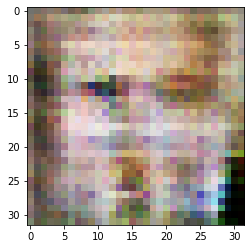

In [36]:
que_se_entreno_m1, prediccion_falsa_m1 = entrenar(gan1, 3000, 150, "resultadosGAN-8")

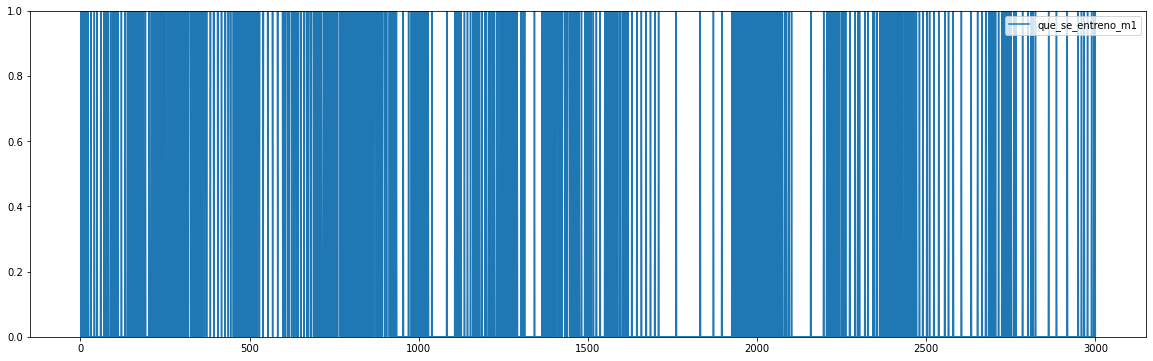

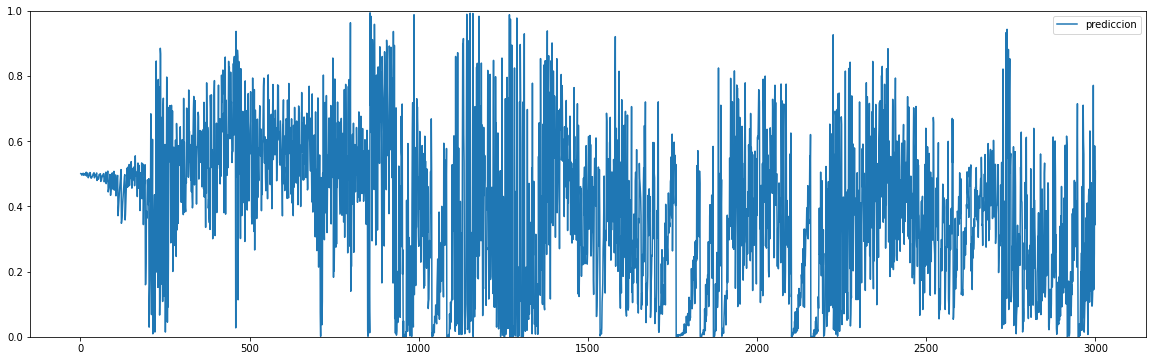

In [37]:
plot_acumulado(len(que_se_entreno_m1), 1, que_se_entreno_m1 = que_se_entreno_m1) #1 para discrimiando, 0 para generador
plot_acumulado(len(prediccion_falsa_m1), 1, prediccion = prediccion_falsa_m1)

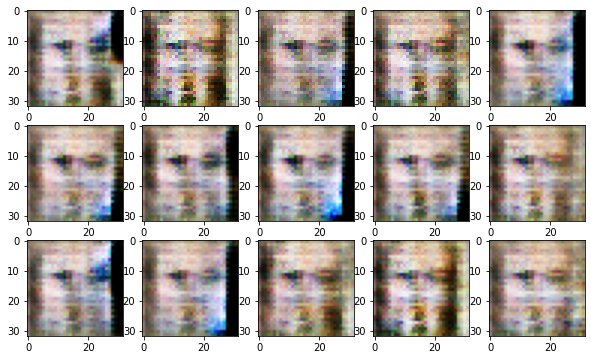

In [39]:
visualizarMosaico(gan1, 3, 5)

Comenzando Epoca 1. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.93 s
Tiempo restante aprox: 96.4m -> 1:36h
prediccion de ruido:  [[0.70574987]]
Comenzando Epoca 2. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.88 s
Tiempo restante aprox: 93.87m -> 1:33h
prediccion de ruido:  [[0.13175634]]
Comenzando Epoca 3. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 47.79m -> 0:47h
prediccion de ruido:  [[0.30587062]]
Comenzando Epoca 4. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 48.37m -> 0:48h
prediccion de ruido:  [[0.75584817]]
Comenzando Epoca 5. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.85 s
Tiempo restante aprox: 92.54m -> 1:32h
prediccion de ruido:  [[0.742412]]
Comenzando Epoca 6. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 46.05m -> 0:46h
prediccion de ruido:  [[0.63465875]]
Comenzando Epoca 7. Entrenenamos Discriminador.. Fin
Tiempo transcurri

Comenzando Epoca 38. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 84.19m -> 1:24h
prediccion de ruido:  [[0.46813694]]
Comenzando Epoca 39. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 46.02m -> 0:46h
prediccion de ruido:  [[0.69542325]]
Comenzando Epoca 40. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 45.33m -> 0:45h
prediccion de ruido:  [[0.6313583]]
Comenzando Epoca 41. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 46.23m -> 0:46h
prediccion de ruido:  [[0.6208582]]
Comenzando Epoca 42. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.89 s
Tiempo restante aprox: 93.39m -> 1:33h
prediccion de ruido:  [[0.49277917]]
Comenzando Epoca 43. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 49.33m -> 0:49h
prediccion de ruido:  [[0.48591655]]
Comenzando Epoca 44. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 75. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 47.85m -> 0:47h
prediccion de ruido:  [[0.64168]]
Comenzando Epoca 76. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.89 s
Tiempo restante aprox: 92.02m -> 1:32h
prediccion de ruido:  [[0.46393016]]
Comenzando Epoca 77. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 48.26m -> 0:48h
prediccion de ruido:  [[0.14332992]]
Comenzando Epoca 78. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 44.84m -> 0:44h
prediccion de ruido:  [[0.34949866]]
Comenzando Epoca 79. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 44.82m -> 0:44h
prediccion de ruido:  [[0.56853]]
Comenzando Epoca 80. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 45.57m -> 0:45h
prediccion de ruido:  [[0.46693346]]
Comenzando Epoca 81. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s

Comenzando Epoca 112. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 46.9m -> 0:46h
prediccion de ruido:  [[0.60858387]]
Comenzando Epoca 113. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 47.22m -> 0:47h
prediccion de ruido:  [[0.39368853]]
Comenzando Epoca 114. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.84 s
Tiempo restante aprox: 88.74m -> 1:28h
prediccion de ruido:  [[0.2506501]]
Comenzando Epoca 115. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 48.87m -> 0:48h
prediccion de ruido:  [[0.48684913]]
Comenzando Epoca 116. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 47.66m -> 0:47h
prediccion de ruido:  [[0.34226704]]
Comenzando Epoca 117. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 47.06m -> 0:47h
prediccion de ruido:  [[0.59179616]]
Comenzando Epoca 118. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 149. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.87 s
Tiempo restante aprox: 88.9m -> 1:28h
prediccion de ruido:  [[0.25781047]]
Comenzando Epoca 150. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 47.52m -> 0:47h
prediccion de ruido:  [[0.4118054]]
Comenzando Epoca 151. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 47.84m -> 0:47h
prediccion de ruido:  [[0.4167102]]
Comenzando Epoca 152. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 44.97m -> 0:44h
prediccion de ruido:  [[0.1939711]]
Comenzando Epoca 153. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 45.14m -> 0:45h
prediccion de ruido:  [[0.14863607]]
Comenzando Epoca 154. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 47.45m -> 0:47h
prediccion de ruido:  [[0.26121154]]
Comenzando Epoca 155. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 186. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 43.92m -> 0:43h
prediccion de ruido:  [[0.41914088]]
Comenzando Epoca 187. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 42.96m -> 0:42h
prediccion de ruido:  [[0.17164493]]
Comenzando Epoca 188. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 43.51m -> 0:43h
prediccion de ruido:  [[0.54552674]]
Comenzando Epoca 189. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 44.15m -> 0:44h
prediccion de ruido:  [[0.5538002]]
Comenzando Epoca 190. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 44.88m -> 0:44h
prediccion de ruido:  [[0.33369988]]
Comenzando Epoca 191. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 45.9m -> 0:45h
prediccion de ruido:  [[0.45777008]]
Comenzando Epoca 192. Entrenenamos Generador. Fin
Tiempo transcurrido:  

Comenzando Epoca 223. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 45.33m -> 0:45h
prediccion de ruido:  [[0.4782613]]
Comenzando Epoca 224. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 44.95m -> 0:44h
prediccion de ruido:  [[0.2517263]]
Comenzando Epoca 225. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 45.07m -> 0:45h
prediccion de ruido:  [[0.35450417]]
Comenzando Epoca 226. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 44.96m -> 0:44h
prediccion de ruido:  [[0.6006572]]
Comenzando Epoca 227. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 44.94m -> 0:44h
prediccion de ruido:  [[0.38283542]]
Comenzando Epoca 228. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.85 s
Tiempo restante aprox: 85.65m -> 1:25h
prediccion de ruido:  [[0.01912707]]
Comenzando Epoca 229. Entrenenamos Generador. Fin
Tiempo transcurrid

Comenzando Epoca 260. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 79.99m -> 1:19h
prediccion de ruido:  [[0.06047153]]
Comenzando Epoca 261. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 42.38m -> 0:42h
prediccion de ruido:  [[0.04488242]]
Comenzando Epoca 262. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 41.82m -> 0:41h
prediccion de ruido:  [[0.13008052]]
Comenzando Epoca 263. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 41.85m -> 0:41h
prediccion de ruido:  [[0.04847533]]
Comenzando Epoca 264. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 41.51m -> 0:41h
prediccion de ruido:  [[0.14219555]]
Comenzando Epoca 265. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 41.82m -> 0:41h
prediccion de ruido:  [[0.21359584]]
Comenzando Epoca 266. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 297. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 40.92m -> 0:40h
prediccion de ruido:  [[0.21688673]]
Comenzando Epoca 298. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 41.09m -> 0:41h
prediccion de ruido:  [[0.5068602]]
Comenzando Epoca 299. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 40.94m -> 0:40h
prediccion de ruido:  [[0.45437628]]
Comenzando Epoca 300. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 46.19m -> 0:46h
prediccion de ruido:  [[0.8138279]]
Comenzando Epoca 301. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 41.76m -> 0:41h
prediccion de ruido:  [[0.50837576]]
Comenzando Epoca 302. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.79 s
Tiempo restante aprox: 80.43m -> 1:20h
prediccion de ruido:  [[0.34591538]]
Comenzando Epoca 303. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 334. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 41.7m -> 0:41h
prediccion de ruido:  [[0.5987967]]
Comenzando Epoca 335. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 43.46m -> 0:43h
prediccion de ruido:  [[0.63110083]]
Comenzando Epoca 336. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 42.02m -> 0:42h
prediccion de ruido:  [[0.35391694]]
Comenzando Epoca 337. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 40.67m -> 0:40h
prediccion de ruido:  [[0.8391849]]
Comenzando Epoca 338. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 77.85m -> 1:17h
prediccion de ruido:  [[0.25882554]]
Comenzando Epoca 339. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 42.15m -> 0:42h
prediccion de ruido:  [[0.24601555]]
Comenzando Epoca 340. Entrenenamos Discriminador.. Fin
Tiempo transc

Comenzando Epoca 371. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 42.17m -> 0:42h
prediccion de ruido:  [[0.54440546]]
Comenzando Epoca 372. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 42.59m -> 0:42h
prediccion de ruido:  [[0.66248083]]
Comenzando Epoca 373. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.9 s
Tiempo restante aprox: 83.18m -> 1:23h
prediccion de ruido:  [[0.7133631]]
Comenzando Epoca 374. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.02 s
Tiempo restante aprox: 88.4m -> 1:28h
prediccion de ruido:  [[0.65172184]]
Comenzando Epoca 375. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.88 s
Tiempo restante aprox: 82.46m -> 1:22h
prediccion de ruido:  [[0.6881376]]
Comenzando Epoca 376. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 43.31m -> 0:43h
prediccion de ruido:  [[0.6330863]]
Comenzando Epoca 377. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 408. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 75.2m -> 1:15h
prediccion de ruido:  [[0.24356234]]
Comenzando Epoca 409. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 40.0m -> 0:40h
prediccion de ruido:  [[0.40144855]]
Comenzando Epoca 410. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 40.03m -> 0:40h
prediccion de ruido:  [[0.19924971]]
Comenzando Epoca 411. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 39.97m -> 0:39h
prediccion de ruido:  [[0.5761266]]
Comenzando Epoca 412. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.81 s
Tiempo restante aprox: 78.19m -> 1:18h
prediccion de ruido:  [[0.4135899]]
Comenzando Epoca 413. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 44.0m -> 0:43h
prediccion de ruido:  [[0.20078099]]
Comenzando Epoca 414. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 445. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 39.15m -> 0:39h
prediccion de ruido:  [[0.3800555]]
Comenzando Epoca 446. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 40.88m -> 0:40h
prediccion de ruido:  [[0.3744923]]
Comenzando Epoca 447. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 41.63m -> 0:41h
prediccion de ruido:  [[0.3647673]]
Comenzando Epoca 448. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 39.15m -> 0:39h
prediccion de ruido:  [[0.4579899]]
Comenzando Epoca 449. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 38.79m -> 0:38h
prediccion de ruido:  [[0.39104292]]
Comenzando Epoca 450. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 41.96m -> 0:41h
prediccion de ruido:  [[0.4210112]]
Comenzando Epoca 451. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9

Comenzando Epoca 482. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 38.54m -> 0:38h
prediccion de ruido:  [[0.07040316]]
Comenzando Epoca 483. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 38.44m -> 0:38h
prediccion de ruido:  [[0.18335521]]
Comenzando Epoca 484. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 38.51m -> 0:38h
prediccion de ruido:  [[0.3007428]]
Comenzando Epoca 485. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 38.12m -> 0:38h
prediccion de ruido:  [[0.22048542]]
Comenzando Epoca 486. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 38.52m -> 0:38h
prediccion de ruido:  [[0.15807441]]
Comenzando Epoca 487. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 38.47m -> 0:38h
prediccion de ruido:  [[0.14075857]]
Comenzando Epoca 488. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 519. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 37.64m -> 0:37h
prediccion de ruido:  [[0.2527699]]
Comenzando Epoca 520. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 37.96m -> 0:37h
prediccion de ruido:  [[0.42311442]]
Comenzando Epoca 521. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 37.86m -> 0:37h
prediccion de ruido:  [[0.3798005]]
Comenzando Epoca 522. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 37.93m -> 0:37h
prediccion de ruido:  [[0.5499633]]
Comenzando Epoca 523. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 37.96m -> 0:37h
prediccion de ruido:  [[0.5490678]]
Comenzando Epoca 524. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 37.9m -> 0:37h
prediccion de ruido:  [[0.53907216]]
Comenzando Epoca 525. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:

Comenzando Epoca 556. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 38.31m -> 0:38h
prediccion de ruido:  [[0.6529155]]
Comenzando Epoca 557. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.79 s
Tiempo restante aprox: 72.91m -> 1:12h
prediccion de ruido:  [[0.00044075]]
Comenzando Epoca 558. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 38.19m -> 0:38h
prediccion de ruido:  [[0.00136927]]
Comenzando Epoca 559. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 37.85m -> 0:37h
prediccion de ruido:  [[0.00667182]]
Comenzando Epoca 560. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 37.35m -> 0:37h
prediccion de ruido:  [[0.01245117]]
Comenzando Epoca 561. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 37.33m -> 0:37h
prediccion de ruido:  [[0.07236597]]
Comenzando Epoca 562. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 593. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 36.76m -> 0:36h
prediccion de ruido:  [[0.03660962]]
Comenzando Epoca 594. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 37.15m -> 0:37h
prediccion de ruido:  [[0.02422151]]
Comenzando Epoca 595. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 36.49m -> 0:36h
prediccion de ruido:  [[0.02105087]]
Comenzando Epoca 596. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 36.96m -> 0:36h
prediccion de ruido:  [[0.06538606]]
Comenzando Epoca 597. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 36.78m -> 0:36h
prediccion de ruido:  [[0.1362895]]
Comenzando Epoca 598. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 36.69m -> 0:36h
prediccion de ruido:  [[0.12724969]]
Comenzando Epoca 599. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 630. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 35.8m -> 0:35h
prediccion de ruido:  [[0.0067367]]
Comenzando Epoca 631. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 36.26m -> 0:36h
prediccion de ruido:  [[0.00850755]]
Comenzando Epoca 632. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 35.93m -> 0:35h
prediccion de ruido:  [[0.01388368]]
Comenzando Epoca 633. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 36.23m -> 0:36h
prediccion de ruido:  [[0.01336616]]
Comenzando Epoca 634. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 35.9m -> 0:35h
prediccion de ruido:  [[0.01197559]]
Comenzando Epoca 635. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 35.73m -> 0:35h
prediccion de ruido:  [[0.02409214]]
Comenzando Epoca 636. Entrenenamos Generador. Fin
Tiempo transcurrido:  0

Comenzando Epoca 667. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.79m -> 0:35h
prediccion de ruido:  [[0.36021277]]
Comenzando Epoca 668. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 35.31m -> 0:35h
prediccion de ruido:  [[0.61536723]]
Comenzando Epoca 669. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.76m -> 0:35h
prediccion de ruido:  [[0.42798176]]
Comenzando Epoca 670. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 35.35m -> 0:35h
prediccion de ruido:  [[0.3774945]]
Comenzando Epoca 671. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 67.03m -> 1:7h
prediccion de ruido:  [[0.00177249]]
Comenzando Epoca 672. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.71m -> 0:35h
prediccion de ruido:  [[0.03735948]]
Comenzando Epoca 673. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 704. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.07m -> 0:35h
prediccion de ruido:  [[0.75514704]]
Comenzando Epoca 705. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 65.9m -> 1:5h
prediccion de ruido:  [[0.00979736]]
Comenzando Epoca 706. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.11m -> 0:35h
prediccion de ruido:  [[0.0879631]]
Comenzando Epoca 707. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 34.79m -> 0:34h
prediccion de ruido:  [[0.3270517]]
Comenzando Epoca 708. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.08m -> 0:35h
prediccion de ruido:  [[0.23380917]]
Comenzando Epoca 709. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.14m -> 0:35h
prediccion de ruido:  [[0.4768517]]
Comenzando Epoca 710. Entrenenamos Discriminador.. Fin
Tiempo transcur

Comenzando Epoca 741. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 34.96m -> 0:34h
prediccion de ruido:  [[0.10621366]]
Comenzando Epoca 742. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 34.56m -> 0:34h
prediccion de ruido:  [[0.20698732]]
Comenzando Epoca 743. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 34.47m -> 0:34h
prediccion de ruido:  [[0.14875051]]
Comenzando Epoca 744. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 34.31m -> 0:34h
prediccion de ruido:  [[0.46613798]]
Comenzando Epoca 745. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 34.89m -> 0:34h
prediccion de ruido:  [[0.7259314]]
Comenzando Epoca 746. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 34.13m -> 0:34h
prediccion de ruido:  [[0.13840094]]
Comenzando Epoca 747. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 778. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 34.38m -> 0:34h
prediccion de ruido:  [[0.5064713]]
Comenzando Epoca 779. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 34.0m -> 0:33h
prediccion de ruido:  [[0.47526318]]
Comenzando Epoca 780. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 33.91m -> 0:33h
prediccion de ruido:  [[0.625569]]
Comenzando Epoca 781. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 33.97m -> 0:33h
prediccion de ruido:  [[0.4530077]]
Comenzando Epoca 782. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 34.03m -> 0:34h
prediccion de ruido:  [[0.5528572]]
Comenzando Epoca 783. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 34.31m -> 0:34h
prediccion de ruido:  [[0.6273202]]
Comenzando Epoca 784. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  

Comenzando Epoca 815. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 33.45m -> 0:33h
prediccion de ruido:  [[0.6909176]]
Comenzando Epoca 816. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 33.07m -> 0:33h
prediccion de ruido:  [[0.4120283]]
Comenzando Epoca 817. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 62.32m -> 1:2h
prediccion de ruido:  [[0.08169559]]
Comenzando Epoca 818. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 33.55m -> 0:33h
prediccion de ruido:  [[0.13593665]]
Comenzando Epoca 819. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 33.46m -> 0:33h
prediccion de ruido:  [[0.13337249]]
Comenzando Epoca 820. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 32.93m -> 0:32h
prediccion de ruido:  [[0.3229499]]
Comenzando Epoca 821. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 852. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 32.52m -> 0:32h
prediccion de ruido:  [[0.5320058]]
Comenzando Epoca 853. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 32.87m -> 0:32h
prediccion de ruido:  [[0.1931768]]
Comenzando Epoca 854. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 32.74m -> 0:32h
prediccion de ruido:  [[0.11825007]]
Comenzando Epoca 855. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 33.19m -> 0:33h
prediccion de ruido:  [[0.17124379]]
Comenzando Epoca 856. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 32.53m -> 0:32h
prediccion de ruido:  [[0.42827514]]
Comenzando Epoca 857. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 32.8m -> 0:32h
prediccion de ruido:  [[0.7519435]]
Comenzando Epoca 858. Entrenenamos Discriminador.. Fin
Tiempo transcurrido

Comenzando Epoca 889. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 32.28m -> 0:32h
prediccion de ruido:  [[0.81106144]]
Comenzando Epoca 890. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 60.45m -> 1:0h
prediccion de ruido:  [[0.25595087]]
Comenzando Epoca 891. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 31.72m -> 0:31h
prediccion de ruido:  [[0.18596551]]
Comenzando Epoca 892. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 32.27m -> 0:32h
prediccion de ruido:  [[0.3279583]]
Comenzando Epoca 893. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 32.29m -> 0:32h
prediccion de ruido:  [[0.6999798]]
Comenzando Epoca 894. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 32.24m -> 0:32h
prediccion de ruido:  [[0.4865665]]
Comenzando Epoca 895. Entrenenamos Generador. Fin
Tiempo transcurrido:

Comenzando Epoca 926. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 31.47m -> 0:31h
prediccion de ruido:  [[0.45073077]]
Comenzando Epoca 927. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 31.46m -> 0:31h
prediccion de ruido:  [[0.43901238]]
Comenzando Epoca 928. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 31.72m -> 0:31h
prediccion de ruido:  [[0.26829702]]
Comenzando Epoca 929. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 31.5m -> 0:31h
prediccion de ruido:  [[0.5112214]]
Comenzando Epoca 930. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 31.48m -> 0:31h
prediccion de ruido:  [[0.316496]]
Comenzando Epoca 931. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 31.67m -> 0:31h
prediccion de ruido:  [[0.22083244]]
Comenzando Epoca 932. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.

Comenzando Epoca 963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 30.77m -> 0:30h
prediccion de ruido:  [[0.14896789]]
Comenzando Epoca 964. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 31.03m -> 0:31h
prediccion de ruido:  [[0.6358793]]
Comenzando Epoca 965. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 32.48m -> 0:32h
prediccion de ruido:  [[0.62223154]]
Comenzando Epoca 966. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 31.44m -> 0:31h
prediccion de ruido:  [[0.4345755]]
Comenzando Epoca 967. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 57.83m -> 0:57h
prediccion de ruido:  [[0.00891235]]
Comenzando Epoca 968. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 31.17m -> 0:31h
prediccion de ruido:  [[0.00416782]]
Comenzando Epoca 969. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 1000. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 35.35m -> 0:35h
prediccion de ruido:  [[0.05054891]]
Comenzando Epoca 1001. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 30.6m -> 0:30h
prediccion de ruido:  [[0.52739227]]
Comenzando Epoca 1002. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 31.25m -> 0:31h
prediccion de ruido:  [[0.06541839]]
Comenzando Epoca 1003. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 30.57m -> 0:30h
prediccion de ruido:  [[0.02594677]]
Comenzando Epoca 1004. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 30.55m -> 0:30h
prediccion de ruido:  [[0.45774153]]
Comenzando Epoca 1005. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 30.81m -> 0:30h
prediccion de ruido:  [[0.0723359]]
Comenzando Epoca 1006. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 1037. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 29.72m -> 0:29h
prediccion de ruido:  [[0.35379303]]
Comenzando Epoca 1038. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 30.03m -> 0:30h
prediccion de ruido:  [[0.25622827]]
Comenzando Epoca 1039. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.95m -> 0:29h
prediccion de ruido:  [[0.5817038]]
Comenzando Epoca 1040. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 30.07m -> 0:30h
prediccion de ruido:  [[0.37573543]]
Comenzando Epoca 1041. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 29.73m -> 0:29h
prediccion de ruido:  [[0.5048596]]
Comenzando Epoca 1042. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.97m -> 0:29h
prediccion de ruido:  [[0.5847243]]
Comenzando Epoca 1043. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 1074. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.55m -> 0:29h
prediccion de ruido:  [[0.42159992]]
Comenzando Epoca 1075. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.47m -> 0:29h
prediccion de ruido:  [[0.40610006]]
Comenzando Epoca 1076. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.39m -> 0:29h
prediccion de ruido:  [[0.618949]]
Comenzando Epoca 1077. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 29.18m -> 0:29h
prediccion de ruido:  [[0.7267821]]
Comenzando Epoca 1078. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.42m -> 0:29h
prediccion de ruido:  [[0.46390462]]
Comenzando Epoca 1079. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.54m -> 0:29h
prediccion de ruido:  [[0.38126117]]
Comenzando Epoca 1080. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 1111. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 28.67m -> 0:28h
prediccion de ruido:  [[0.3362282]]
Comenzando Epoca 1112. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.9m -> 0:28h
prediccion de ruido:  [[0.34525242]]
Comenzando Epoca 1113. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 28.64m -> 0:28h
prediccion de ruido:  [[0.39521605]]
Comenzando Epoca 1114. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.81m -> 0:28h
prediccion de ruido:  [[0.41200125]]
Comenzando Epoca 1115. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.86m -> 0:28h
prediccion de ruido:  [[0.30211562]]
Comenzando Epoca 1116. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 28.53m -> 0:28h
prediccion de ruido:  [[0.30234277]]
Comenzando Epoca 1117. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 1148. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.35m -> 0:28h
prediccion de ruido:  [[0.5387998]]
Comenzando Epoca 1149. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 28.09m -> 0:28h
prediccion de ruido:  [[0.49929777]]
Comenzando Epoca 1150. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 52.82m -> 0:52h
prediccion de ruido:  [[0.16549695]]
Comenzando Epoca 1151. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 28.37m -> 0:28h
prediccion de ruido:  [[0.25932205]]
Comenzando Epoca 1152. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 30.26m -> 0:30h
prediccion de ruido:  [[0.4781395]]
Comenzando Epoca 1153. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 30.49m -> 0:30h
prediccion de ruido:  [[0.867676]]
Comenzando Epoca 1154. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 1185. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.73m -> 0:27h
prediccion de ruido:  [[0.49110562]]
Comenzando Epoca 1186. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 52.09m -> 0:52h
prediccion de ruido:  [[0.4579816]]
Comenzando Epoca 1187. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 27.51m -> 0:27h
prediccion de ruido:  [[0.21070698]]
Comenzando Epoca 1188. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.8m -> 0:27h
prediccion de ruido:  [[0.30022365]]
Comenzando Epoca 1189. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.72m -> 0:27h
prediccion de ruido:  [[0.26824188]]
Comenzando Epoca 1190. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.65m -> 0:27h
prediccion de ruido:  [[0.39660707]]
Comenzando Epoca 1191. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 1222. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.28m -> 0:27h
prediccion de ruido:  [[0.36460507]]
Comenzando Epoca 1223. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.14m -> 0:27h
prediccion de ruido:  [[0.4144826]]
Comenzando Epoca 1224. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.19m -> 0:27h
prediccion de ruido:  [[0.5862557]]
Comenzando Epoca 1225. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 26.88m -> 0:26h
prediccion de ruido:  [[0.58339393]]
Comenzando Epoca 1226. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.16m -> 0:27h
prediccion de ruido:  [[0.4931595]]
Comenzando Epoca 1227. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 51.0m -> 0:51h
prediccion de ruido:  [[0.23186883]]
Comenzando Epoca 1228. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 1259. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 26.71m -> 0:26h
prediccion de ruido:  [[0.5582219]]
Comenzando Epoca 1260. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 26.49m -> 0:26h
prediccion de ruido:  [[0.40576506]]
Comenzando Epoca 1261. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 26.56m -> 0:26h
prediccion de ruido:  [[0.24157748]]
Comenzando Epoca 1262. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 26.38m -> 0:26h
prediccion de ruido:  [[0.59283817]]
Comenzando Epoca 1263. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 49.94m -> 0:49h
prediccion de ruido:  [[0.49367258]]
Comenzando Epoca 1264. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 26.29m -> 0:26h
prediccion de ruido:  [[0.11202812]]
Comenzando Epoca 1265. Entrenenamos Generador. Fin
Tiempo tr

Comenzando Epoca 1296. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 25.75m -> 0:25h
prediccion de ruido:  [[0.39177287]]
Comenzando Epoca 1297. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 25.73m -> 0:25h
prediccion de ruido:  [[0.34793538]]
Comenzando Epoca 1298. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 25.83m -> 0:25h
prediccion de ruido:  [[0.34578934]]
Comenzando Epoca 1299. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 26.01m -> 0:26h
prediccion de ruido:  [[0.5116675]]
Comenzando Epoca 1300. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 30.85m -> 0:30h
prediccion de ruido:  [[0.2000922]]
Comenzando Epoca 1301. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.95m -> 0:25h
prediccion de ruido:  [[0.4823257]]
Comenzando Epoca 1302. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 1333. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.52m -> 0:25h
prediccion de ruido:  [[0.34598202]]
Comenzando Epoca 1334. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 25.28m -> 0:25h
prediccion de ruido:  [[0.47084138]]
Comenzando Epoca 1335. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.43m -> 0:25h
prediccion de ruido:  [[0.42325953]]
Comenzando Epoca 1336. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.42m -> 0:25h
prediccion de ruido:  [[0.25935602]]
Comenzando Epoca 1337. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.46m -> 0:25h
prediccion de ruido:  [[0.47077695]]
Comenzando Epoca 1338. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 25.44m -> 0:25h
prediccion de ruido:  [[0.4058656]]
Comenzando Epoca 1339. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1370. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 46.59m -> 0:46h
prediccion de ruido:  [[0.49878508]]
Comenzando Epoca 1371. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 24.94m -> 0:24h
prediccion de ruido:  [[0.6095286]]
Comenzando Epoca 1372. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 24.95m -> 0:24h
prediccion de ruido:  [[0.5388609]]
Comenzando Epoca 1373. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 46.81m -> 0:46h
prediccion de ruido:  [[0.73255336]]
Comenzando Epoca 1374. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 24.68m -> 0:24h
prediccion de ruido:  [[0.617316]]
Comenzando Epoca 1375. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 47.29m -> 0:47h
prediccion de ruido:  [[0.54986286]]
Comenzando Epoca 1376. Entrenenamos Generador. Fin
Ti

Comenzando Epoca 1407. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 24.18m -> 0:24h
prediccion de ruido:  [[0.22748771]]
Comenzando Epoca 1408. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 24.37m -> 0:24h
prediccion de ruido:  [[0.21524087]]
Comenzando Epoca 1409. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 24.41m -> 0:24h
prediccion de ruido:  [[0.5509257]]
Comenzando Epoca 1410. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 24.34m -> 0:24h
prediccion de ruido:  [[0.5148655]]
Comenzando Epoca 1411. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 24.04m -> 0:24h
prediccion de ruido:  [[0.57844406]]
Comenzando Epoca 1412. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 45.37m -> 0:45h
prediccion de ruido:  [[0.19493237]]
Comenzando Epoca 1413. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 1444. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 23.56m -> 0:23h
prediccion de ruido:  [[0.25415888]]
Comenzando Epoca 1445. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.91m -> 0:23h
prediccion de ruido:  [[0.54414296]]
Comenzando Epoca 1446. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 23.58m -> 0:23h
prediccion de ruido:  [[0.15841836]]
Comenzando Epoca 1447. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.83m -> 0:23h
prediccion de ruido:  [[0.2934786]]
Comenzando Epoca 1448. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.81m -> 0:23h
prediccion de ruido:  [[0.40464213]]
Comenzando Epoca 1449. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 23.46m -> 0:23h
prediccion de ruido:  [[0.30672085]]
Comenzando Epoca 1450. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1481. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 43.6m -> 0:43h
prediccion de ruido:  [[0.39080837]]
Comenzando Epoca 1482. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.29m -> 0:23h
prediccion de ruido:  [[0.5382121]]
Comenzando Epoca 1483. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 43.74m -> 0:43h
prediccion de ruido:  [[0.5608856]]
Comenzando Epoca 1484. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.26m -> 0:23h
prediccion de ruido:  [[0.5480275]]
Comenzando Epoca 1485. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 43.79m -> 0:43h
prediccion de ruido:  [[0.355529]]
Comenzando Epoca 1486. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 23.48m -> 0:23h
prediccion de ruido:  [[0.45994398]]
Comenzando Epoca 1487. Entrenenamos Generador. Fin
Tiem

Comenzando Epoca 1518. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.79m -> 0:22h
prediccion de ruido:  [[0.34719396]]
Comenzando Epoca 1519. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.63m -> 0:22h
prediccion de ruido:  [[0.3745967]]
Comenzando Epoca 1520. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.61m -> 0:22h
prediccion de ruido:  [[0.34679955]]
Comenzando Epoca 1521. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.69m -> 0:22h
prediccion de ruido:  [[0.27125233]]
Comenzando Epoca 1522. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.63m -> 0:22h
prediccion de ruido:  [[0.5220929]]
Comenzando Epoca 1523. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 22.86m -> 0:22h
prediccion de ruido:  [[0.5550356]]
Comenzando Epoca 1524. Entrenenamos Discriminador.. Fin
Tiempo tran

Comenzando Epoca 1555. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.08m -> 0:22h
prediccion de ruido:  [[0.34629464]]
Comenzando Epoca 1556. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 22.64m -> 0:22h
prediccion de ruido:  [[0.3233269]]
Comenzando Epoca 1557. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.09m -> 0:22h
prediccion de ruido:  [[0.339209]]
Comenzando Epoca 1558. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 22.32m -> 0:22h
prediccion de ruido:  [[0.36652866]]
Comenzando Epoca 1559. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.11m -> 0:22h
prediccion de ruido:  [[0.5910459]]
Comenzando Epoca 1560. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.1m -> 0:22h
prediccion de ruido:  [[0.40050888]]
Comenzando Epoca 1561. Entrenenamos Generador. Fin
Tiempo transcurrid

Comenzando Epoca 1592. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.58m -> 0:21h
prediccion de ruido:  [[0.51790935]]
Comenzando Epoca 1593. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 40.97m -> 0:40h
prediccion de ruido:  [[0.31480247]]
Comenzando Epoca 1594. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.53m -> 0:21h
prediccion de ruido:  [[0.38155589]]
Comenzando Epoca 1595. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.47m -> 0:21h
prediccion de ruido:  [[0.31575772]]
Comenzando Epoca 1596. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 21.73m -> 0:21h
prediccion de ruido:  [[0.4088762]]
Comenzando Epoca 1597. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.53m -> 0:21h
prediccion de ruido:  [[0.247397]]
Comenzando Epoca 1598. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1629. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 39.7m -> 0:39h
prediccion de ruido:  [[0.38291037]]
Comenzando Epoca 1630. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 21.16m -> 0:21h
prediccion de ruido:  [[0.5598295]]
Comenzando Epoca 1631. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 20.96m -> 0:20h
prediccion de ruido:  [[0.3563766]]
Comenzando Epoca 1632. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 21.17m -> 0:21h
prediccion de ruido:  [[0.48446503]]
Comenzando Epoca 1633. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 39.56m -> 0:39h
prediccion de ruido:  [[0.60399383]]
Comenzando Epoca 1634. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 20.96m -> 0:20h
prediccion de ruido:  [[0.5240259]]
Comenzando Epoca 1635. Entrenenamos Generador. Fin
Tiempo 

Comenzando Epoca 1666. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 20.69m -> 0:20h
prediccion de ruido:  [[0.44796282]]
Comenzando Epoca 1667. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 38.6m -> 0:38h
prediccion de ruido:  [[0.4831747]]
Comenzando Epoca 1668. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 38.66m -> 0:38h
prediccion de ruido:  [[0.5749559]]
Comenzando Epoca 1669. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.78 s
Tiempo restante aprox: 39.56m -> 0:39h
prediccion de ruido:  [[0.71919316]]
Comenzando Epoca 1670. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.76 s
Tiempo restante aprox: 39.09m -> 0:39h
prediccion de ruido:  [[0.59547883]]
Comenzando Epoca 1671. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 38.53m -> 0:38h
prediccion de ruido:  [[0.46722642]]
Comenzando Epoca 1672. Entrenenamos Genera

Comenzando Epoca 1739. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 36.56m -> 0:36h
prediccion de ruido:  [[0.39114222]]
Comenzando Epoca 1740. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 19.46m -> 0:19h
prediccion de ruido:  [[0.4181008]]
Comenzando Epoca 1741. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 19.28m -> 0:19h
prediccion de ruido:  [[0.42141324]]
Comenzando Epoca 1742. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 19.52m -> 0:19h
prediccion de ruido:  [[0.53746367]]
Comenzando Epoca 1743. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 19.12m -> 0:19h
prediccion de ruido:  [[0.5073245]]
Comenzando Epoca 1744. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 36.5m -> 0:36h
prediccion de ruido:  [[0.5567249]]
Comenzando Epoca 1745. Entrenenamos Generador. Fin
Tiempo 

Comenzando Epoca 1776. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 18.95m -> 0:18h
prediccion de ruido:  [[0.3045916]]
Comenzando Epoca 1777. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 18.93m -> 0:18h
prediccion de ruido:  [[0.41271213]]
Comenzando Epoca 1778. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 18.75m -> 0:18h
prediccion de ruido:  [[0.40570623]]
Comenzando Epoca 1779. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 18.86m -> 0:18h
prediccion de ruido:  [[0.4783463]]
Comenzando Epoca 1780. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 18.68m -> 0:18h
prediccion de ruido:  [[0.5643635]]
Comenzando Epoca 1781. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 18.83m -> 0:18h
prediccion de ruido:  [[0.5149495]]
Comenzando Epoca 1782. Entrenenamos Discriminador.. Fin
Tiempo trans

Comenzando Epoca 1813. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 18.34m -> 0:18h
prediccion de ruido:  [[0.38375452]]
Comenzando Epoca 1814. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 18.2m -> 0:18h
prediccion de ruido:  [[0.35917717]]
Comenzando Epoca 1815. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 18.19m -> 0:18h
prediccion de ruido:  [[0.53585523]]
Comenzando Epoca 1816. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 34.21m -> 0:34h
prediccion de ruido:  [[0.07014939]]
Comenzando Epoca 1817. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 18.16m -> 0:18h
prediccion de ruido:  [[0.09928897]]
Comenzando Epoca 1818. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 18.14m -> 0:18h
prediccion de ruido:  [[0.14875224]]
Comenzando Epoca 1819. Entrenenamos Generador. Fin
Tiempo tr

Comenzando Epoca 1850. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 17.76m -> 0:17h
prediccion de ruido:  [[0.58671117]]
Comenzando Epoca 1851. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 33.27m -> 0:33h
prediccion de ruido:  [[0.07471535]]
Comenzando Epoca 1852. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 17.58m -> 0:17h
prediccion de ruido:  [[0.09514394]]
Comenzando Epoca 1853. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 17.76m -> 0:17h
prediccion de ruido:  [[0.1086964]]
Comenzando Epoca 1854. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 17.4m -> 0:17h
prediccion de ruido:  [[0.09896874]]
Comenzando Epoca 1855. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 17.73m -> 0:17h
prediccion de ruido:  [[0.11012441]]
Comenzando Epoca 1856. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 1887. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 17.56m -> 0:17h
prediccion de ruido:  [[0.43177834]]
Comenzando Epoca 1888. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 17.33m -> 0:17h
prediccion de ruido:  [[0.41059253]]
Comenzando Epoca 1889. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 17.24m -> 0:17h
prediccion de ruido:  [[0.415465]]
Comenzando Epoca 1890. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 17.07m -> 0:17h
prediccion de ruido:  [[0.5158255]]
Comenzando Epoca 1891. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 16.87m -> 0:16h
prediccion de ruido:  [[0.4956915]]
Comenzando Epoca 1892. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 17.12m -> 0:17h
prediccion de ruido:  [[0.55275875]]
Comenzando Epoca 1893. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 1924. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 16.55m -> 0:16h
prediccion de ruido:  [[0.12162092]]
Comenzando Epoca 1925. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 16.71m -> 0:16h
prediccion de ruido:  [[0.14473721]]
Comenzando Epoca 1926. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 16.45m -> 0:16h
prediccion de ruido:  [[0.15711331]]
Comenzando Epoca 1927. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 16.52m -> 0:16h
prediccion de ruido:  [[0.1274648]]
Comenzando Epoca 1928. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 16.6m -> 0:16h
prediccion de ruido:  [[0.20335433]]
Comenzando Epoca 1929. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 16.22m -> 0:16h
prediccion de ruido:  [[0.17362437]]
Comenzando Epoca 1930. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 1961. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.91m -> 0:15h
prediccion de ruido:  [[0.00335124]]
Comenzando Epoca 1962. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 16.04m -> 0:16h
prediccion de ruido:  [[0.00473943]]
Comenzando Epoca 1963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.85m -> 0:15h
prediccion de ruido:  [[0.00786024]]
Comenzando Epoca 1964. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.9m -> 0:15h
prediccion de ruido:  [[0.00847051]]
Comenzando Epoca 1965. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 15.75m -> 0:15h
prediccion de ruido:  [[0.00989723]]
Comenzando Epoca 1966. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 16.04m -> 0:16h
prediccion de ruido:  [[0.0125128]]
Comenzando Epoca 1967. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 1998. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 15.25m -> 0:15h
prediccion de ruido:  [[0.14654666]]
Comenzando Epoca 1999. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.33m -> 0:15h
prediccion de ruido:  [[0.21045974]]
Comenzando Epoca 2000. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.13 s
Tiempo restante aprox: 18.82m -> 0:18h
prediccion de ruido:  [[0.15953404]]
Comenzando Epoca 2001. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 15.47m -> 0:15h
prediccion de ruido:  [[0.31766844]]
Comenzando Epoca 2002. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 15.49m -> 0:15h
prediccion de ruido:  [[0.10130244]]
Comenzando Epoca 2003. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.34m -> 0:15h
prediccion de ruido:  [[0.2726897]]
Comenzando Epoca 2004. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 2035. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.78m -> 0:14h
prediccion de ruido:  [[0.42410716]]
Comenzando Epoca 2036. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.8m -> 0:14h
prediccion de ruido:  [[0.227362]]
Comenzando Epoca 2037. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 14.88m -> 0:14h
prediccion de ruido:  [[0.488031]]
Comenzando Epoca 2038. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.77m -> 0:14h
prediccion de ruido:  [[0.5935455]]
Comenzando Epoca 2039. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.82m -> 0:14h
prediccion de ruido:  [[0.51886594]]
Comenzando Epoca 2040. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.7m -> 0:14h
prediccion de ruido:  [[0.33805448]]
Comenzando Epoca 2041. Entrenenamos Generador. Fin
Tiempo transcurrido:

Comenzando Epoca 2072. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.28m -> 0:14h
prediccion de ruido:  [[0.5820861]]
Comenzando Epoca 2073. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.23m -> 0:14h
prediccion de ruido:  [[0.5098573]]
Comenzando Epoca 2074. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 26.98m -> 0:26h
prediccion de ruido:  [[0.37891424]]
Comenzando Epoca 2075. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.23m -> 0:14h
prediccion de ruido:  [[0.2368033]]
Comenzando Epoca 2076. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 26.61m -> 0:26h
prediccion de ruido:  [[0.02139893]]
Comenzando Epoca 2077. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 14.29m -> 0:14h
prediccion de ruido:  [[0.13519478]]
Comenzando Epoca 2078. Entrenenamos Generador. Fin
Tiempo

Comenzando Epoca 2109. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 13.8m -> 0:13h
prediccion de ruido:  [[0.36603856]]
Comenzando Epoca 2110. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.63m -> 0:13h
prediccion de ruido:  [[0.5895273]]
Comenzando Epoca 2111. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.62m -> 0:13h
prediccion de ruido:  [[0.428258]]
Comenzando Epoca 2112. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 13.75m -> 0:13h
prediccion de ruido:  [[0.5503837]]
Comenzando Epoca 2113. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 25.87m -> 0:25h
prediccion de ruido:  [[0.08196613]]
Comenzando Epoca 2114. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.63m -> 0:13h
prediccion de ruido:  [[0.13618544]]
Comenzando Epoca 2115. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 2146. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 13.25m -> 0:13h
prediccion de ruido:  [[0.82360053]]
Comenzando Epoca 2147. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 24.74m -> 0:24h
prediccion de ruido:  [[0.34004897]]
Comenzando Epoca 2148. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.08m -> 0:13h
prediccion de ruido:  [[0.41086367]]
Comenzando Epoca 2149. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.04m -> 0:13h
prediccion de ruido:  [[0.3040014]]
Comenzando Epoca 2150. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 13.3m -> 0:13h
prediccion de ruido:  [[0.50453883]]
Comenzando Epoca 2151. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 12.93m -> 0:12h
prediccion de ruido:  [[0.37679273]]
Comenzando Epoca 2152. Entrenenamos Discriminador.. Fin
Tiemp

Comenzando Epoca 2183. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 12.54m -> 0:12h
prediccion de ruido:  [[0.6683544]]
Comenzando Epoca 2184. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 12.58m -> 0:12h
prediccion de ruido:  [[0.34082323]]
Comenzando Epoca 2185. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 23.76m -> 0:23h
prediccion de ruido:  [[0.64792293]]
Comenzando Epoca 2186. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 12.61m -> 0:12h
prediccion de ruido:  [[0.6575279]]
Comenzando Epoca 2187. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 23.53m -> 0:23h
prediccion de ruido:  [[0.31879264]]
Comenzando Epoca 2188. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 12.55m -> 0:12h
prediccion de ruido:  [[0.21122134]]
Comenzando Epoca 2189. Entrenenamos Generador. Fin
Tiemp

Comenzando Epoca 2220. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 12.08m -> 0:12h
prediccion de ruido:  [[0.62515855]]
Comenzando Epoca 2221. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.96m -> 0:11h
prediccion de ruido:  [[0.7160659]]
Comenzando Epoca 2222. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.95m -> 0:11h
prediccion de ruido:  [[0.49919125]]
Comenzando Epoca 2223. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 22.5m -> 0:22h
prediccion de ruido:  [[0.32979655]]
Comenzando Epoca 2224. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.86m -> 0:11h
prediccion de ruido:  [[0.2860019]]
Comenzando Epoca 2225. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 12.03m -> 0:12h
prediccion de ruido:  [[0.40351808]]
Comenzando Epoca 2226. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 2257. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.41m -> 0:11h
prediccion de ruido:  [[0.4374448]]
Comenzando Epoca 2258. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.37m -> 0:11h
prediccion de ruido:  [[0.40900978]]
Comenzando Epoca 2259. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 11.45m -> 0:11h
prediccion de ruido:  [[0.37377]]
Comenzando Epoca 2260. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 11.49m -> 0:11h
prediccion de ruido:  [[0.4976638]]
Comenzando Epoca 2261. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 11.45m -> 0:11h
prediccion de ruido:  [[0.50166607]]
Comenzando Epoca 2262. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.31m -> 0:11h
prediccion de ruido:  [[0.4975172]]
Comenzando Epoca 2263. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 2294. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 10.91m -> 0:10h
prediccion de ruido:  [[0.35304868]]
Comenzando Epoca 2295. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 20.43m -> 0:20h
prediccion de ruido:  [[0.4187805]]
Comenzando Epoca 2296. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 11.63m -> 0:11h
prediccion de ruido:  [[0.7581655]]
Comenzando Epoca 2297. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 11.76m -> 0:11h
prediccion de ruido:  [[0.4303369]]
Comenzando Epoca 2298. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 11.74m -> 0:11h
prediccion de ruido:  [[0.37609962]]
Comenzando Epoca 2299. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 10.98m -> 0:10h
prediccion de ruido:  [[0.46740818]]
Comenzando Epoca 2300. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 2331. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 10.18m -> 0:10h
prediccion de ruido:  [[0.4022445]]
Comenzando Epoca 2332. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 10.35m -> 0:10h
prediccion de ruido:  [[0.41035187]]
Comenzando Epoca 2333. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.2m -> 0:10h
prediccion de ruido:  [[0.35023332]]
Comenzando Epoca 2334. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.23m -> 0:10h
prediccion de ruido:  [[0.3359521]]
Comenzando Epoca 2335. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 10.32m -> 0:10h
prediccion de ruido:  [[0.4080971]]
Comenzando Epoca 2336. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 10.29m -> 0:10h
prediccion de ruido:  [[0.4426803]]
Comenzando Epoca 2337. Entrenenamos Generador. Fin
Tiempo transcurrid

Comenzando Epoca 2368. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 9.88m -> 0:9h
prediccion de ruido:  [[0.04138306]]
Comenzando Epoca 2369. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.67m -> 0:9h
prediccion de ruido:  [[0.04747027]]
Comenzando Epoca 2370. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.68m -> 0:9h
prediccion de ruido:  [[0.06050786]]
Comenzando Epoca 2371. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.64m -> 0:9h
prediccion de ruido:  [[0.3043481]]
Comenzando Epoca 2372. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 9.73m -> 0:9h
prediccion de ruido:  [[0.08964315]]
Comenzando Epoca 2373. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.63m -> 0:9h
prediccion de ruido:  [[0.4480394]]
Comenzando Epoca 2374. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 

Comenzando Epoca 2405. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.14m -> 0:9h
prediccion de ruido:  [[0.02125996]]
Comenzando Epoca 2406. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.08m -> 0:9h
prediccion de ruido:  [[0.0350945]]
Comenzando Epoca 2407. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 9.17m -> 0:9h
prediccion de ruido:  [[0.05187285]]
Comenzando Epoca 2408. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.07m -> 0:9h
prediccion de ruido:  [[0.03793627]]
Comenzando Epoca 2409. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 9.18m -> 0:9h
prediccion de ruido:  [[0.02651417]]
Comenzando Epoca 2410. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.06m -> 0:9h
prediccion de ruido:  [[0.02653411]]
Comenzando Epoca 2411. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92

Comenzando Epoca 2442. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 8.5m -> 0:8h
prediccion de ruido:  [[0.28314245]]
Comenzando Epoca 2443. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 8.54m -> 0:8h
prediccion de ruido:  [[0.46938822]]
Comenzando Epoca 2444. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 8.54m -> 0:8h
prediccion de ruido:  [[0.24854997]]
Comenzando Epoca 2445. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 8.51m -> 0:8h
prediccion de ruido:  [[0.05701834]]
Comenzando Epoca 2446. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 8.58m -> 0:8h
prediccion de ruido:  [[0.48380777]]
Comenzando Epoca 2447. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 8.49m -> 0:8h
prediccion de ruido:  [[0.27451926]]
Comenzando Epoca 2448. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92

Comenzando Epoca 2479. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 8.12m -> 0:8h
prediccion de ruido:  [[0.07243967]]
Comenzando Epoca 2480. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.98m -> 0:7h
prediccion de ruido:  [[0.183698]]
Comenzando Epoca 2481. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.94m -> 0:7h
prediccion de ruido:  [[0.08543491]]
Comenzando Epoca 2482. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 8.04m -> 0:8h
prediccion de ruido:  [[0.10856825]]
Comenzando Epoca 2483. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.93m -> 0:7h
prediccion de ruido:  [[0.17762262]]
Comenzando Epoca 2484. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 8.0m -> 0:7h
prediccion de ruido:  [[0.22440168]]
Comenzando Epoca 2485. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s

Comenzando Epoca 2516. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 7.5m -> 0:7h
prediccion de ruido:  [[0.37108392]]
Comenzando Epoca 2517. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.42m -> 0:7h
prediccion de ruido:  [[0.34910083]]
Comenzando Epoca 2518. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.41m -> 0:7h
prediccion de ruido:  [[0.29635495]]
Comenzando Epoca 2519. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.36m -> 0:7h
prediccion de ruido:  [[0.348863]]
Comenzando Epoca 2520. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 7.47m -> 0:7h
prediccion de ruido:  [[0.3274948]]
Comenzando Epoca 2521. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.36m -> 0:7h
prediccion de ruido:  [[0.3879643]]
Comenzando Epoca 2522. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
T

Comenzando Epoca 2553. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 13.02m -> 0:13h
prediccion de ruido:  [[0.44139883]]
Comenzando Epoca 2554. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.87m -> 0:6h
prediccion de ruido:  [[0.17528841]]
Comenzando Epoca 2555. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.87m -> 0:6h
prediccion de ruido:  [[0.55612427]]
Comenzando Epoca 2556. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 12.96m -> 0:12h
prediccion de ruido:  [[0.19033548]]
Comenzando Epoca 2557. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.79m -> 0:6h
prediccion de ruido:  [[0.3696959]]
Comenzando Epoca 2558. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.74 s
Tiempo restante aprox: 12.83m -> 0:12h
prediccion de ruido:  [[0.33728525]]
Comenzando Epoca 2559. Entrenenamos Generador. Fin
Tiemp

Comenzando Epoca 2590. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 6.44m -> 0:6h
prediccion de ruido:  [[0.07606009]]
Comenzando Epoca 2591. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.26m -> 0:6h
prediccion de ruido:  [[0.10411492]]
Comenzando Epoca 2592. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 6.33m -> 0:6h
prediccion de ruido:  [[0.04423869]]
Comenzando Epoca 2593. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.26m -> 0:6h
prediccion de ruido:  [[0.12507069]]
Comenzando Epoca 2594. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.24m -> 0:6h
prediccion de ruido:  [[0.05776489]]
Comenzando Epoca 2595. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 6.24m -> 0:6h
prediccion de ruido:  [[0.2553414]]
Comenzando Epoca 2596. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92

Comenzando Epoca 2627. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 5.81m -> 0:5h
prediccion de ruido:  [[0.1754351]]
Comenzando Epoca 2628. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.72m -> 0:5h
prediccion de ruido:  [[0.5811826]]
Comenzando Epoca 2629. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 10.71m -> 0:10h
prediccion de ruido:  [[0.39636546]]
Comenzando Epoca 2630. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 5.64m -> 0:5h
prediccion de ruido:  [[0.42097533]]
Comenzando Epoca 2631. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.65m -> 0:5h
prediccion de ruido:  [[0.26715654]]
Comenzando Epoca 2632. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.66m -> 0:5h
prediccion de ruido:  [[0.23522061]]
Comenzando Epoca 2633. Entrenenamos Generador. Fin
Tiempo transcurrido:

Comenzando Epoca 2664. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 5.2m -> 0:5h
prediccion de ruido:  [[0.225299]]
Comenzando Epoca 2665. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 5.2m -> 0:5h
prediccion de ruido:  [[0.54287386]]
Comenzando Epoca 2666. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 9.6m -> 0:9h
prediccion de ruido:  [[0.23692611]]
Comenzando Epoca 2667. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.11m -> 0:5h
prediccion de ruido:  [[0.19726402]]
Comenzando Epoca 2668. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 5.21m -> 0:5h
prediccion de ruido:  [[0.66836363]]
Comenzando Epoca 2669. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.1m -> 0:5h
prediccion de ruido:  [[0.24724951]]
Comenzando Epoca 2670. Entrenenamos Discriminador.. Fin
Tiempo transcurrido: 

Comenzando Epoca 2701. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.78 s
Tiempo restante aprox: 8.9m -> 0:8h
prediccion de ruido:  [[0.01876974]]
Comenzando Epoca 2702. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 4.62m -> 0:4h
prediccion de ruido:  [[0.18422812]]
Comenzando Epoca 2703. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.55m -> 0:4h
prediccion de ruido:  [[0.11888492]]
Comenzando Epoca 2704. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 4.59m -> 0:4h
prediccion de ruido:  [[0.39737958]]
Comenzando Epoca 2705. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.55m -> 0:4h
prediccion de ruido:  [[0.4796604]]
Comenzando Epoca 2706. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 4.57m -> 0:4h
prediccion de ruido:  [[0.31257135]]
Comenzando Epoca 2707. Entrenenamos Generador. Fin
Tiempo transcurrido:  

Comenzando Epoca 2738. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.02m -> 0:4h
prediccion de ruido:  [[0.400538]]
Comenzando Epoca 2739. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.02m -> 0:4h
prediccion de ruido:  [[0.37919515]]
Comenzando Epoca 2740. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.99m -> 0:3h
prediccion de ruido:  [[0.43152788]]
Comenzando Epoca 2741. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.0m -> 0:3h
prediccion de ruido:  [[0.4735652]]
Comenzando Epoca 2742. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.97m -> 0:3h
prediccion de ruido:  [[0.4954326]]
Comenzando Epoca 2743. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.96m -> 0:3h
prediccion de ruido:  [[0.6447158]]
Comenzando Epoca 2744. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Ti

Comenzando Epoca 2775. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.46m -> 0:3h
prediccion de ruido:  [[0.38275188]]
Comenzando Epoca 2776. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.44m -> 0:3h
prediccion de ruido:  [[0.31494224]]
Comenzando Epoca 2777. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.43m -> 0:3h
prediccion de ruido:  [[0.41709113]]
Comenzando Epoca 2778. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.43m -> 0:3h
prediccion de ruido:  [[0.49884805]]
Comenzando Epoca 2779. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 3.43m -> 0:3h
prediccion de ruido:  [[0.45340487]]
Comenzando Epoca 2780. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.38m -> 0:3h
prediccion de ruido:  [[0.48516446]]
Comenzando Epoca 2781. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:

Comenzando Epoca 2812. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 2.92m -> 0:2h
prediccion de ruido:  [[0.4791235]]
Comenzando Epoca 2813. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.88m -> 0:2h
prediccion de ruido:  [[0.42536217]]
Comenzando Epoca 2814. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 2.89m -> 0:2h
prediccion de ruido:  [[0.5134532]]
Comenzando Epoca 2815. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.85m -> 0:2h
prediccion de ruido:  [[0.40033865]]
Comenzando Epoca 2816. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 2.81m -> 0:2h
prediccion de ruido:  [[0.4692662]]
Comenzando Epoca 2817. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 2.8m -> 0:2h
prediccion de ruido:  [[0.4157695]]
Comenzando Epoca 2818. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
T

Comenzando Epoca 2849. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.33m -> 0:2h
prediccion de ruido:  [[0.39968115]]
Comenzando Epoca 2850. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.31m -> 0:2h
prediccion de ruido:  [[0.26578605]]
Comenzando Epoca 2851. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.3m -> 0:2h
prediccion de ruido:  [[0.44261748]]
Comenzando Epoca 2852. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.28m -> 0:2h
prediccion de ruido:  [[0.3893531]]
Comenzando Epoca 2853. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 2.28m -> 0:2h
prediccion de ruido:  [[0.3679366]]
Comenzando Epoca 2854. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 2.24m -> 0:2h
prediccion de ruido:  [[0.21066996]]
Comenzando Epoca 2855. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s

Comenzando Epoca 2886. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 1.78m -> 0:1h
prediccion de ruido:  [[0.35127836]]
Comenzando Epoca 2887. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 1.73m -> 0:1h
prediccion de ruido:  [[0.51613116]]
Comenzando Epoca 2888. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.73m -> 0:1h
prediccion de ruido:  [[0.5801552]]
Comenzando Epoca 2889. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 1.73m -> 0:1h
prediccion de ruido:  [[0.19721293]]
Comenzando Epoca 2890. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 1.71m -> 0:1h
prediccion de ruido:  [[0.38963982]]
Comenzando Epoca 2891. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 1.66m -> 0:1h
prediccion de ruido:  [[0.40443993]]
Comenzando Epoca 2892. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93

Comenzando Epoca 2923. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 1.21m -> 0:1h
prediccion de ruido:  [[0.3249202]]
Comenzando Epoca 2924. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.18m -> 0:1h
prediccion de ruido:  [[0.36875796]]
Comenzando Epoca 2925. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 1.18m -> 0:1h
prediccion de ruido:  [[0.52101934]]
Comenzando Epoca 2926. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.15m -> 0:1h
prediccion de ruido:  [[0.1968047]]
Comenzando Epoca 2927. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.13m -> 0:1h
prediccion de ruido:  [[0.21318486]]
Comenzando Epoca 2928. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.12m -> 0:1h
prediccion de ruido:  [[0.39500955]]
Comenzando Epoca 2929. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 

Comenzando Epoca 2960. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 0.63m -> 0:0h
prediccion de ruido:  [[0.42992845]]
Comenzando Epoca 2961. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 1.15m -> 0:1h
prediccion de ruido:  [[0.25086576]]
Comenzando Epoca 2962. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 0.6m -> 0:0h
prediccion de ruido:  [[0.27723685]]
Comenzando Epoca 2963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 0.58m -> 0:0h
prediccion de ruido:  [[0.3381125]]
Comenzando Epoca 2964. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 0.58m -> 0:0h
prediccion de ruido:  [[0.32185537]]
Comenzando Epoca 2965. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 0.56m -> 0:0h
prediccion de ruido:  [[0.31868798]]
Comenzando Epoca 2966. Entrenenamos Generador. Fin
Tiempo transcurrido:  

Comenzando Epoca 2997. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 0.06m -> 0:0h
prediccion de ruido:  [[0.45333412]]
Comenzando Epoca 2998. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.05m -> 0:0h
prediccion de ruido:  [[0.46228126]]
Comenzando Epoca 2999. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.03m -> 0:0h
prediccion de ruido:  [[0.33997396]]
Comenzando Epoca 3000. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.18 s
Tiempo restante aprox: 0.02m -> 0:0h
prediccion de ruido:  [[0.45209524]]


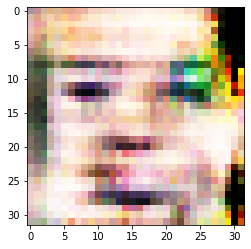

In [40]:
que_se_entreno_m1, prediccion_falsa_m1 = entrenar(gan1, 3000, 150, "resultadosGAN-8")

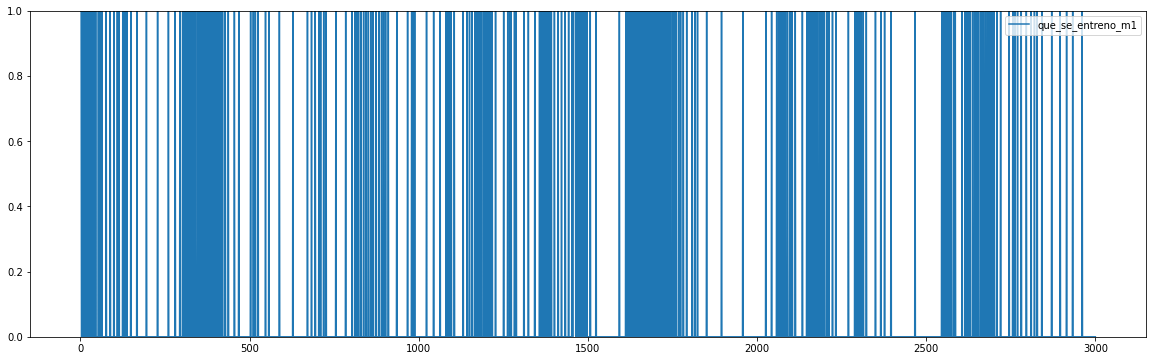

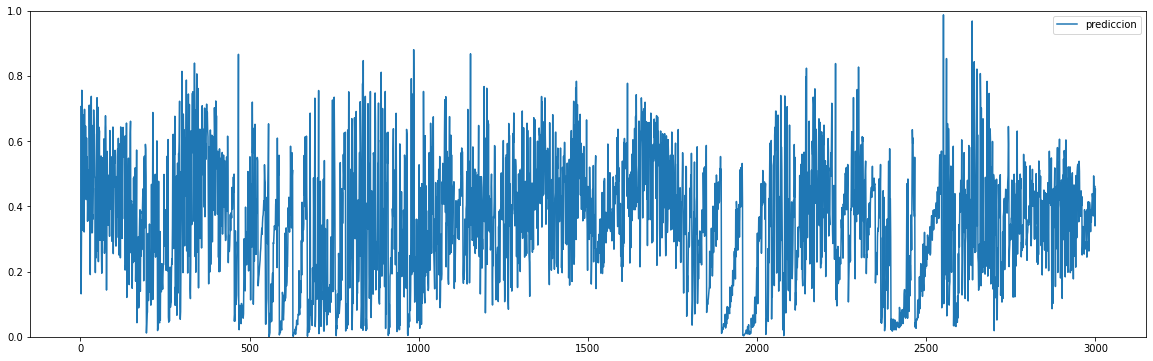

In [41]:
plot_acumulado(len(que_se_entreno_m1), 1, que_se_entreno_m1 = que_se_entreno_m1) #1 para discrimiando, 0 para generador
plot_acumulado(len(prediccion_falsa_m1), 1, prediccion = prediccion_falsa_m1)

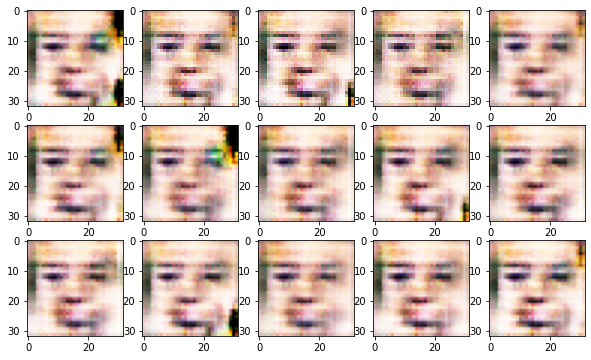

In [42]:
visualizarMosaico(gan1, 3, 5)

Comenzando Epoca 1. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 55.35m -> 0:55h
prediccion de ruido:  [[0.39417672]]
Comenzando Epoca 2. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 48.94m -> 0:48h
prediccion de ruido:  [[0.4546833]]
Comenzando Epoca 3. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 51.17m -> 0:51h
prediccion de ruido:  [[0.39879707]]
Comenzando Epoca 4. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 46.66m -> 0:46h
prediccion de ruido:  [[0.4768916]]
Comenzando Epoca 5. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 47.49m -> 0:47h
prediccion de ruido:  [[0.5250521]]
Comenzando Epoca 6. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 50.62m -> 0:50h
prediccion de ruido:  [[0.4568626]]
Comenzando Epoca 7. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo re

Comenzando Epoca 38. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 53.54m -> 0:53h
prediccion de ruido:  [[0.2777868]]
Comenzando Epoca 39. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 47.64m -> 0:47h
prediccion de ruido:  [[0.24476424]]
Comenzando Epoca 40. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 53.25m -> 0:53h
prediccion de ruido:  [[0.32270545]]
Comenzando Epoca 41. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 48.6m -> 0:48h
prediccion de ruido:  [[0.2796719]]
Comenzando Epoca 42. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 45.47m -> 0:45h
prediccion de ruido:  [[0.19488281]]
Comenzando Epoca 43. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 46.05m -> 0:46h
prediccion de ruido:  [[0.25109518]]
Comenzando Epoca 44. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
T

Comenzando Epoca 75. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.1 s
Tiempo restante aprox: 53.45m -> 0:53h
prediccion de ruido:  [[0.34808868]]
Comenzando Epoca 76. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.12 s
Tiempo restante aprox: 54.75m -> 0:54h
prediccion de ruido:  [[0.3763402]]
Comenzando Epoca 77. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 52.64m -> 0:52h
prediccion de ruido:  [[0.25486505]]
Comenzando Epoca 78. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 52.91m -> 0:52h
prediccion de ruido:  [[0.48649776]]
Comenzando Epoca 79. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.1 s
Tiempo restante aprox: 53.72m -> 0:53h
prediccion de ruido:  [[0.4059784]]
Comenzando Epoca 80. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 52.63m -> 0:52h
prediccion de ruido:  [[0.41833153]]
Comenzando Epoca 81. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Ti

Comenzando Epoca 112. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 50.9m -> 0:50h
prediccion de ruido:  [[0.32500136]]
Comenzando Epoca 113. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 51.17m -> 0:51h
prediccion de ruido:  [[0.322475]]
Comenzando Epoca 114. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 50.14m -> 0:50h
prediccion de ruido:  [[0.10572359]]
Comenzando Epoca 115. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 52.29m -> 0:52h
prediccion de ruido:  [[0.2413297]]
Comenzando Epoca 116. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 49.92m -> 0:49h
prediccion de ruido:  [[0.54121953]]
Comenzando Epoca 117. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 50.96m -> 0:50h
prediccion de ruido:  [[0.1204541]]
Comenzando Epoca 118. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0

Comenzando Epoca 149. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 49.53m -> 0:49h
prediccion de ruido:  [[0.4490462]]
Comenzando Epoca 150. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 49.99m -> 0:49h
prediccion de ruido:  [[0.18106964]]
Comenzando Epoca 151. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 50.55m -> 0:50h
prediccion de ruido:  [[0.4239936]]
Comenzando Epoca 152. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 49.81m -> 0:49h
prediccion de ruido:  [[0.51320124]]
Comenzando Epoca 153. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 50.89m -> 0:50h
prediccion de ruido:  [[0.7070799]]
Comenzando Epoca 154. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 50.59m -> 0:50h
prediccion de ruido:  [[0.5328406]]
Comenzando Epoca 155. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.

Comenzando Epoca 186. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 46.64m -> 0:46h
prediccion de ruido:  [[0.46138027]]
Comenzando Epoca 187. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.88 s
Tiempo restante aprox: 88.09m -> 1:28h
prediccion de ruido:  [[0.16704646]]
Comenzando Epoca 188. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 46.61m -> 0:46h
prediccion de ruido:  [[0.12318262]]
Comenzando Epoca 189. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 48.61m -> 0:48h
prediccion de ruido:  [[0.12051252]]
Comenzando Epoca 190. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 48.35m -> 0:48h
prediccion de ruido:  [[0.11825565]]
Comenzando Epoca 191. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 48.34m -> 0:48h
prediccion de ruido:  [[0.3494308]]
Comenzando Epoca 192. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 223. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 48.67m -> 0:48h
prediccion de ruido:  [[0.5118472]]
Comenzando Epoca 224. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 47.26m -> 0:47h
prediccion de ruido:  [[0.6554411]]
Comenzando Epoca 225. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 45.99m -> 0:45h
prediccion de ruido:  [[0.6082423]]
Comenzando Epoca 226. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 45.65m -> 0:45h
prediccion de ruido:  [[0.41568375]]
Comenzando Epoca 227. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 45.73m -> 0:45h
prediccion de ruido:  [[0.5994908]]
Comenzando Epoca 228. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.97 s
Tiempo restante aprox: 91.24m -> 1:31h
prediccion de ruido:  [[0.13128358]]
Comenzando Epoca 229. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 260. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 47.93m -> 0:47h
prediccion de ruido:  [[0.18379632]]
Comenzando Epoca 261. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 49.1m -> 0:49h
prediccion de ruido:  [[0.31542158]]
Comenzando Epoca 262. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 48.3m -> 0:48h
prediccion de ruido:  [[0.25394404]]
Comenzando Epoca 263. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 48.42m -> 0:48h
prediccion de ruido:  [[0.31752688]]
Comenzando Epoca 264. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 48.18m -> 0:48h
prediccion de ruido:  [[0.3844524]]
Comenzando Epoca 265. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 48.25m -> 0:48h
prediccion de ruido:  [[0.45869166]]
Comenzando Epoca 266. Entrenenamos Generador. Fin
Tiempo transcurrido:  1

Comenzando Epoca 297. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 48.09m -> 0:48h
prediccion de ruido:  [[0.2659589]]
Comenzando Epoca 298. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 47.71m -> 0:47h
prediccion de ruido:  [[0.46901065]]
Comenzando Epoca 299. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 46.93m -> 0:46h
prediccion de ruido:  [[0.2996825]]
Comenzando Epoca 300. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.19 s
Tiempo restante aprox: 53.62m -> 0:53h
prediccion de ruido:  [[0.49053264]]
Comenzando Epoca 301. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.12 s
Tiempo restante aprox: 50.45m -> 0:50h
prediccion de ruido:  [[0.3868361]]
Comenzando Epoca 302. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 48.14m -> 0:48h
prediccion de ruido:  [[0.3950797]]
Comenzando Epoca 303. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.

Comenzando Epoca 334. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 46.28m -> 0:46h
prediccion de ruido:  [[0.3756147]]
Comenzando Epoca 335. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 46.44m -> 0:46h
prediccion de ruido:  [[0.37012002]]
Comenzando Epoca 336. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 45.98m -> 0:45h
prediccion de ruido:  [[0.5259202]]
Comenzando Epoca 337. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 46.94m -> 0:46h
prediccion de ruido:  [[0.53767705]]
Comenzando Epoca 338. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.97 s
Tiempo restante aprox: 87.4m -> 1:27h
prediccion de ruido:  [[0.11374775]]
Comenzando Epoca 339. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 46.23m -> 0:46h
prediccion de ruido:  [[0.0806832]]
Comenzando Epoca 340. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 371. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 45.07m -> 0:45h
prediccion de ruido:  [[0.471762]]
Comenzando Epoca 372. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 44.87m -> 0:44h
prediccion de ruido:  [[0.5034347]]
Comenzando Epoca 373. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 44.55m -> 0:44h
prediccion de ruido:  [[0.5150739]]
Comenzando Epoca 374. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 46.24m -> 0:46h
prediccion de ruido:  [[0.40605676]]
Comenzando Epoca 375. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 46.53m -> 0:46h
prediccion de ruido:  [[0.50499153]]
Comenzando Epoca 376. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 45.55m -> 0:45h
prediccion de ruido:  [[0.4566366]]
Comenzando Epoca 377. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0

Comenzando Epoca 408. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 45.6m -> 0:45h
prediccion de ruido:  [[0.44976172]]
Comenzando Epoca 409. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 46.96m -> 0:46h
prediccion de ruido:  [[0.28689986]]
Comenzando Epoca 410. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 45.43m -> 0:45h
prediccion de ruido:  [[0.45069125]]
Comenzando Epoca 411. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 45.76m -> 0:45h
prediccion de ruido:  [[0.44538158]]
Comenzando Epoca 412. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 45.1m -> 0:45h
prediccion de ruido:  [[0.2069923]]
Comenzando Epoca 413. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 45.98m -> 0:45h
prediccion de ruido:  [[0.51973027]]
Comenzando Epoca 414. Entrenenamos Generador. Fin
Tiempo transcurrido:  1

Comenzando Epoca 445. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 44.14m -> 0:44h
prediccion de ruido:  [[0.15698063]]
Comenzando Epoca 446. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 45.23m -> 0:45h
prediccion de ruido:  [[0.30063874]]
Comenzando Epoca 447. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 44.83m -> 0:44h
prediccion de ruido:  [[0.65772855]]
Comenzando Epoca 448. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 45.58m -> 0:45h
prediccion de ruido:  [[0.5334785]]
Comenzando Epoca 449. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 44.37m -> 0:44h
prediccion de ruido:  [[0.5134833]]
Comenzando Epoca 450. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.98 s
Tiempo restante aprox: 84.28m -> 1:24h
prediccion de ruido:  [[0.30592287]]
Comenzando Epoca 451. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 482. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 40.98m -> 0:40h
prediccion de ruido:  [[0.48443297]]
Comenzando Epoca 483. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 41.17m -> 0:41h
prediccion de ruido:  [[0.27405077]]
Comenzando Epoca 484. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 41.49m -> 0:41h
prediccion de ruido:  [[0.6306695]]
Comenzando Epoca 485. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 41.43m -> 0:41h
prediccion de ruido:  [[0.5489511]]
Comenzando Epoca 486. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.88 s
Tiempo restante aprox: 78.85m -> 1:18h
prediccion de ruido:  [[0.10452667]]
Comenzando Epoca 487. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 41.69m -> 0:41h
prediccion de ruido:  [[0.4938672]]
Comenzando Epoca 488. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 519. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 42.94m -> 0:42h
prediccion de ruido:  [[0.52619]]
Comenzando Epoca 520. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 43.46m -> 0:43h
prediccion de ruido:  [[0.19104448]]
Comenzando Epoca 521. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 42.95m -> 0:42h
prediccion de ruido:  [[0.43269435]]
Comenzando Epoca 522. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 42.89m -> 0:42h
prediccion de ruido:  [[0.46115175]]
Comenzando Epoca 523. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 42.79m -> 0:42h
prediccion de ruido:  [[0.55337834]]
Comenzando Epoca 524. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 42.65m -> 0:42h
prediccion de ruido:  [[0.5073625]]
Comenzando Epoca 525. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.

Comenzando Epoca 556. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 42.63m -> 0:42h
prediccion de ruido:  [[0.30683532]]
Comenzando Epoca 557. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 42.69m -> 0:42h
prediccion de ruido:  [[0.3677072]]
Comenzando Epoca 558. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 43.61m -> 0:43h
prediccion de ruido:  [[0.19398332]]
Comenzando Epoca 559. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 43.92m -> 0:43h
prediccion de ruido:  [[0.5435273]]
Comenzando Epoca 560. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 42.88m -> 0:42h
prediccion de ruido:  [[0.5853896]]
Comenzando Epoca 561. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 43.48m -> 0:43h
prediccion de ruido:  [[0.50774056]]
Comenzando Epoca 562. Entrenenamos Discriminador.. Fin
Tiempo transcurrid

Comenzando Epoca 593. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 42.26m -> 0:42h
prediccion de ruido:  [[0.44622794]]
Comenzando Epoca 594. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 41.44m -> 0:41h
prediccion de ruido:  [[0.4498816]]
Comenzando Epoca 595. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 41.83m -> 0:41h
prediccion de ruido:  [[0.5184883]]
Comenzando Epoca 596. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.03 s
Tiempo restante aprox: 81.42m -> 1:21h
prediccion de ruido:  [[0.28598294]]
Comenzando Epoca 597. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 42.43m -> 0:42h
prediccion de ruido:  [[0.3015054]]
Comenzando Epoca 598. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 42.5m -> 0:42h
prediccion de ruido:  [[0.319992]]
Comenzando Epoca 599. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 630. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 41.65m -> 0:41h
prediccion de ruido:  [[0.3873757]]
Comenzando Epoca 631. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 41.76m -> 0:41h
prediccion de ruido:  [[0.3643094]]
Comenzando Epoca 632. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 41.3m -> 0:41h
prediccion de ruido:  [[0.39159536]]
Comenzando Epoca 633. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 42.0m -> 0:41h
prediccion de ruido:  [[0.36415222]]
Comenzando Epoca 634. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 41.94m -> 0:41h
prediccion de ruido:  [[0.3719191]]
Comenzando Epoca 635. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 40.23m -> 0:40h
prediccion de ruido:  [[0.37136567]]
Comenzando Epoca 636. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9

Comenzando Epoca 667. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.05 s
Tiempo restante aprox: 79.82m -> 1:19h
prediccion de ruido:  [[0.1546137]]
Comenzando Epoca 668. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 41.64m -> 0:41h
prediccion de ruido:  [[0.13955653]]
Comenzando Epoca 669. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 40.77m -> 0:40h
prediccion de ruido:  [[0.15226996]]
Comenzando Epoca 670. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 41.14m -> 0:41h
prediccion de ruido:  [[0.14091098]]
Comenzando Epoca 671. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 41.24m -> 0:41h
prediccion de ruido:  [[0.17123413]]
Comenzando Epoca 672. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 40.84m -> 0:40h
prediccion de ruido:  [[0.18643245]]
Comenzando Epoca 673. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 704. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 40.16m -> 0:40h
prediccion de ruido:  [[0.3802699]]
Comenzando Epoca 705. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 40.6m -> 0:40h
prediccion de ruido:  [[0.49558514]]
Comenzando Epoca 706. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 39.82m -> 0:39h
prediccion de ruido:  [[0.44031468]]
Comenzando Epoca 707. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 39.57m -> 0:39h
prediccion de ruido:  [[0.50291437]]
Comenzando Epoca 708. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 41.04m -> 0:41h
prediccion de ruido:  [[0.46227103]]
Comenzando Epoca 709. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 40.03m -> 0:40h
prediccion de ruido:  [[0.45631957]]
Comenzando Epoca 710. Entrenenamos Generador. Fin
Tiempo transcurrido:  

Comenzando Epoca 741. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 39.74m -> 0:39h
prediccion de ruido:  [[0.10398483]]
Comenzando Epoca 742. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 39.91m -> 0:39h
prediccion de ruido:  [[0.13234994]]
Comenzando Epoca 743. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 39.14m -> 0:39h
prediccion de ruido:  [[0.10691375]]
Comenzando Epoca 744. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 39.2m -> 0:39h
prediccion de ruido:  [[0.11651519]]
Comenzando Epoca 745. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 40.27m -> 0:40h
prediccion de ruido:  [[0.16088209]]
Comenzando Epoca 746. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 39.46m -> 0:39h
prediccion de ruido:  [[0.11274084]]
Comenzando Epoca 747. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 778. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 37.68m -> 0:37h
prediccion de ruido:  [[0.26511186]]
Comenzando Epoca 779. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 38.03m -> 0:38h
prediccion de ruido:  [[0.27774736]]
Comenzando Epoca 780. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 38.31m -> 0:38h
prediccion de ruido:  [[0.39124998]]
Comenzando Epoca 781. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 38.52m -> 0:38h
prediccion de ruido:  [[0.41503316]]
Comenzando Epoca 782. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 38.91m -> 0:38h
prediccion de ruido:  [[0.36170003]]
Comenzando Epoca 783. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 39.15m -> 0:39h
prediccion de ruido:  [[0.39289862]]
Comenzando Epoca 784. Entrenenamos Generador. Fin
Tiempo transcurrido:

Comenzando Epoca 815. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 36.11m -> 0:36h
prediccion de ruido:  [[0.3131492]]
Comenzando Epoca 816. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.12 s
Tiempo restante aprox: 40.71m -> 0:40h
prediccion de ruido:  [[0.31245255]]
Comenzando Epoca 817. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 37.82m -> 0:37h
prediccion de ruido:  [[0.28650692]]
Comenzando Epoca 818. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 38.31m -> 0:38h
prediccion de ruido:  [[0.38059232]]
Comenzando Epoca 819. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 37.68m -> 0:37h
prediccion de ruido:  [[0.3487441]]
Comenzando Epoca 820. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 38.24m -> 0:38h
prediccion de ruido:  [[0.339489]]
Comenzando Epoca 821. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.

Comenzando Epoca 852. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 39.11m -> 0:39h
prediccion de ruido:  [[0.14535043]]
Comenzando Epoca 853. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 38.02m -> 0:38h
prediccion de ruido:  [[0.12338665]]
Comenzando Epoca 854. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 38.47m -> 0:38h
prediccion de ruido:  [[0.21298754]]
Comenzando Epoca 855. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 38.66m -> 0:38h
prediccion de ruido:  [[0.13068402]]
Comenzando Epoca 856. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 38.93m -> 0:38h
prediccion de ruido:  [[0.19544014]]
Comenzando Epoca 857. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 38.73m -> 0:38h
prediccion de ruido:  [[0.18593273]]
Comenzando Epoca 858. Entrenenamos Generador. Fin
Tiempo transcurrido:

Comenzando Epoca 889. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 37.38m -> 0:37h
prediccion de ruido:  [[0.4122245]]
Comenzando Epoca 890. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 37.22m -> 0:37h
prediccion de ruido:  [[0.37292206]]
Comenzando Epoca 891. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 36.96m -> 0:36h
prediccion de ruido:  [[0.39517146]]
Comenzando Epoca 892. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 37.89m -> 0:37h
prediccion de ruido:  [[0.3854234]]
Comenzando Epoca 893. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 38.01m -> 0:38h
prediccion de ruido:  [[0.32527554]]
Comenzando Epoca 894. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 36.73m -> 0:36h
prediccion de ruido:  [[0.30173558]]
Comenzando Epoca 895. Entrenenamos Generador. Fin
Tiempo transcurrido:  

Comenzando Epoca 926. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 37.25m -> 0:37h
prediccion de ruido:  [[0.4452935]]
Comenzando Epoca 927. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 37.23m -> 0:37h
prediccion de ruido:  [[0.36894178]]
Comenzando Epoca 928. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.1 s
Tiempo restante aprox: 38.07m -> 0:38h
prediccion de ruido:  [[0.5182132]]
Comenzando Epoca 929. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 38.23m -> 0:38h
prediccion de ruido:  [[0.522834]]
Comenzando Epoca 930. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.1 s
Tiempo restante aprox: 38.07m -> 0:38h
prediccion de ruido:  [[0.4636112]]
Comenzando Epoca 931. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 37.19m -> 0:37h
prediccion de ruido:  [[0.39159012]]
Comenzando Epoca 932. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  

Comenzando Epoca 963. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 36.51m -> 0:36h
prediccion de ruido:  [[0.50386405]]
Comenzando Epoca 964. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 35.31m -> 0:35h
prediccion de ruido:  [[0.3119215]]
Comenzando Epoca 965. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 34.41m -> 0:34h
prediccion de ruido:  [[0.5205016]]
Comenzando Epoca 966. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 34.9m -> 0:34h
prediccion de ruido:  [[0.59950364]]
Comenzando Epoca 967. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 34.68m -> 0:34h
prediccion de ruido:  [[0.62488484]]
Comenzando Epoca 968. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.93 s
Tiempo restante aprox: 65.56m -> 1:5h
prediccion de ruido:  [[0.27318323]]
Comenzando Epoca 969. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 1000. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.2 s
Tiempo restante aprox: 40.02m -> 0:40h
prediccion de ruido:  [[0.26355404]]
Comenzando Epoca 1001. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 37.13m -> 0:37h
prediccion de ruido:  [[0.21124834]]
Comenzando Epoca 1002. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 35.15m -> 0:35h
prediccion de ruido:  [[0.2829489]]
Comenzando Epoca 1003. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 35.23m -> 0:35h
prediccion de ruido:  [[0.3277799]]
Comenzando Epoca 1004. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 34.85m -> 0:34h
prediccion de ruido:  [[0.2284073]]
Comenzando Epoca 1005. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 35.2m -> 0:35h
prediccion de ruido:  [[0.0941903]]
Comenzando Epoca 1006. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 1037. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.02 s
Tiempo restante aprox: 66.02m -> 1:6h
prediccion de ruido:  [[0.30384827]]
Comenzando Epoca 1038. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 34.48m -> 0:34h
prediccion de ruido:  [[0.3626358]]
Comenzando Epoca 1039. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 34.92m -> 0:34h
prediccion de ruido:  [[0.36741674]]
Comenzando Epoca 1040. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 34.19m -> 0:34h
prediccion de ruido:  [[0.39193767]]
Comenzando Epoca 1041. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 33.78m -> 0:33h
prediccion de ruido:  [[0.53143775]]
Comenzando Epoca 1042. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 34.22m -> 0:34h
prediccion de ruido:  [[0.62339884]]
Comenzando Epoca 1043. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 1074. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 32.02m -> 0:32h
prediccion de ruido:  [[0.3292867]]
Comenzando Epoca 1075. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 31.65m -> 0:31h
prediccion de ruido:  [[0.35527864]]
Comenzando Epoca 1076. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 31.67m -> 0:31h
prediccion de ruido:  [[0.43514988]]
Comenzando Epoca 1077. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.92 s
Tiempo restante aprox: 61.41m -> 1:1h
prediccion de ruido:  [[0.23911381]]
Comenzando Epoca 1078. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 31.73m -> 0:31h
prediccion de ruido:  [[0.38482085]]
Comenzando Epoca 1079. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 32.29m -> 0:32h
prediccion de ruido:  [[0.58671206]]
Comenzando Epoca 1080. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1111. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.9 s
Tiempo restante aprox: 59.79m -> 0:59h
prediccion de ruido:  [[0.07553035]]
Comenzando Epoca 1112. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 32.02m -> 0:32h
prediccion de ruido:  [[0.23537514]]
Comenzando Epoca 1113. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 32.16m -> 0:32h
prediccion de ruido:  [[0.10875243]]
Comenzando Epoca 1114. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.18 s
Tiempo restante aprox: 36.95m -> 0:36h
prediccion de ruido:  [[0.5549331]]
Comenzando Epoca 1115. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.26 s
Tiempo restante aprox: 39.76m -> 0:39h
prediccion de ruido:  [[0.52471757]]
Comenzando Epoca 1116. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.3 s
Tiempo restante aprox: 40.78m -> 0:40h
prediccion de ruido:  [[0.58435506]]
Comenzando Epoca 1117. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1148. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 31.56m -> 0:31h
prediccion de ruido:  [[0.3254948]]
Comenzando Epoca 1149. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 32.56m -> 0:32h
prediccion de ruido:  [[0.38506842]]
Comenzando Epoca 1150. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 33.66m -> 0:33h
prediccion de ruido:  [[0.484157]]
Comenzando Epoca 1151. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 33.21m -> 0:33h
prediccion de ruido:  [[0.38712537]]
Comenzando Epoca 1152. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.05 s
Tiempo restante aprox: 63.14m -> 1:3h
prediccion de ruido:  [[0.06917697]]
Comenzando Epoca 1153. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 32.89m -> 0:32h
prediccion de ruido:  [[0.0995675]]
Comenzando Epoca 1154. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 1185. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.1 s
Tiempo restante aprox: 33.41m -> 0:33h
prediccion de ruido:  [[0.53098613]]
Comenzando Epoca 1186. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.1 s
Tiempo restante aprox: 63.62m -> 1:3h
prediccion de ruido:  [[0.14869508]]
Comenzando Epoca 1187. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 32.65m -> 0:32h
prediccion de ruido:  [[0.31385005]]
Comenzando Epoca 1188. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 32.18m -> 0:32h
prediccion de ruido:  [[0.21726573]]
Comenzando Epoca 1189. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 31.71m -> 0:31h
prediccion de ruido:  [[0.13425136]]
Comenzando Epoca 1190. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 31.63m -> 0:31h
prediccion de ruido:  [[0.2986763]]
Comenzando Epoca 1191. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 1222. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 30.9m -> 0:30h
prediccion de ruido:  [[0.23369795]]
Comenzando Epoca 1223. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 31.17m -> 0:31h
prediccion de ruido:  [[0.24989527]]
Comenzando Epoca 1224. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 31.22m -> 0:31h
prediccion de ruido:  [[0.24061409]]
Comenzando Epoca 1225. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 30.81m -> 0:30h
prediccion de ruido:  [[0.26148832]]
Comenzando Epoca 1226. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 31.65m -> 0:31h
prediccion de ruido:  [[0.25528398]]
Comenzando Epoca 1227. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 32.2m -> 0:32h
prediccion de ruido:  [[0.338013]]
Comenzando Epoca 1228. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 1259. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 30.02m -> 0:30h
prediccion de ruido:  [[0.6631023]]
Comenzando Epoca 1260. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 29.34m -> 0:29h
prediccion de ruido:  [[0.6481352]]
Comenzando Epoca 1261. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 29.46m -> 0:29h
prediccion de ruido:  [[0.4056964]]
Comenzando Epoca 1262. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.94 s
Tiempo restante aprox: 56.17m -> 0:56h
prediccion de ruido:  [[0.45624205]]
Comenzando Epoca 1263. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 29.95m -> 0:29h
prediccion de ruido:  [[0.23642483]]
Comenzando Epoca 1264. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 29.27m -> 0:29h
prediccion de ruido:  [[0.4000615]]
Comenzando Epoca 1265. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 1296. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 28.19m -> 0:28h
prediccion de ruido:  [[0.47743145]]
Comenzando Epoca 1297. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 28.4m -> 0:28h
prediccion de ruido:  [[0.4366365]]
Comenzando Epoca 1298. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.93 s
Tiempo restante aprox: 54.75m -> 0:54h
prediccion de ruido:  [[0.30190742]]
Comenzando Epoca 1299. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 29.16m -> 0:29h
prediccion de ruido:  [[0.5371086]]
Comenzando Epoca 1300. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.17 s
Tiempo restante aprox: 33.31m -> 0:33h
prediccion de ruido:  [[0.47145241]]
Comenzando Epoca 1301. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 29.13m -> 0:29h
prediccion de ruido:  [[0.42642802]]
Comenzando Epoca 1302. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 1333. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.1 s
Tiempo restante aprox: 30.58m -> 0:30h
prediccion de ruido:  [[0.5278743]]
Comenzando Epoca 1334. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.12 s
Tiempo restante aprox: 31.15m -> 0:31h
prediccion de ruido:  [[0.48532486]]
Comenzando Epoca 1335. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.03 s
Tiempo restante aprox: 56.34m -> 0:56h
prediccion de ruido:  [[0.36855572]]
Comenzando Epoca 1336. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 29.41m -> 0:29h
prediccion de ruido:  [[0.39660728]]
Comenzando Epoca 1337. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 28.98m -> 0:28h
prediccion de ruido:  [[0.2948212]]
Comenzando Epoca 1338. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 29.07m -> 0:29h
prediccion de ruido:  [[0.37337795]]
Comenzando Epoca 1339. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1370. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 28.9m -> 0:28h
prediccion de ruido:  [[0.23740682]]
Comenzando Epoca 1371. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 29.12m -> 0:29h
prediccion de ruido:  [[0.34452772]]
Comenzando Epoca 1372. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 28.43m -> 0:28h
prediccion de ruido:  [[0.27052122]]
Comenzando Epoca 1373. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 29.2m -> 0:29h
prediccion de ruido:  [[0.4157157]]
Comenzando Epoca 1374. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 28.58m -> 0:28h
prediccion de ruido:  [[0.3352452]]
Comenzando Epoca 1375. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 29.24m -> 0:29h
prediccion de ruido:  [[0.40922853]]
Comenzando Epoca 1376. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 1407. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 27.92m -> 0:27h
prediccion de ruido:  [[0.3977535]]
Comenzando Epoca 1408. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 28.83m -> 0:28h
prediccion de ruido:  [[0.42344755]]
Comenzando Epoca 1409. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 27.97m -> 0:27h
prediccion de ruido:  [[0.4305847]]
Comenzando Epoca 1410. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 28.08m -> 0:28h
prediccion de ruido:  [[0.50436854]]
Comenzando Epoca 1411. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 28.22m -> 0:28h
prediccion de ruido:  [[0.44338244]]
Comenzando Epoca 1412. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 26.93m -> 0:26h
prediccion de ruido:  [[0.3937848]]
Comenzando Epoca 1413. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 1444. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 26.32m -> 0:26h
prediccion de ruido:  [[0.37607056]]
Comenzando Epoca 1445. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 25.1m -> 0:25h
prediccion de ruido:  [[0.4296525]]
Comenzando Epoca 1446. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 26.77m -> 0:26h
prediccion de ruido:  [[0.37865525]]
Comenzando Epoca 1447. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 25.1m -> 0:25h
prediccion de ruido:  [[0.54881185]]
Comenzando Epoca 1448. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.82m -> 0:23h
prediccion de ruido:  [[0.5123204]]
Comenzando Epoca 1449. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.81m -> 0:23h
prediccion de ruido:  [[0.37375838]]
Comenzando Epoca 1450. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 1481. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.32m -> 0:23h
prediccion de ruido:  [[0.06815442]]
Comenzando Epoca 1482. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 23.75m -> 0:23h
prediccion de ruido:  [[0.04867837]]
Comenzando Epoca 1483. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 23.34m -> 0:23h
prediccion de ruido:  [[0.04131913]]
Comenzando Epoca 1484. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 23.95m -> 0:23h
prediccion de ruido:  [[0.05484593]]
Comenzando Epoca 1485. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 23.65m -> 0:23h
prediccion de ruido:  [[0.07073253]]
Comenzando Epoca 1486. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 22.87m -> 0:22h
prediccion de ruido:  [[0.04793835]]
Comenzando Epoca 1487. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 1518. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 23.98m -> 0:23h
prediccion de ruido:  [[0.22958568]]
Comenzando Epoca 1519. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.07 s
Tiempo restante aprox: 26.36m -> 0:26h
prediccion de ruido:  [[0.13449606]]
Comenzando Epoca 1520. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 24.84m -> 0:24h
prediccion de ruido:  [[0.21393564]]
Comenzando Epoca 1521. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 24.06m -> 0:24h
prediccion de ruido:  [[0.17112052]]
Comenzando Epoca 1522. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 24.59m -> 0:24h
prediccion de ruido:  [[0.13327432]]
Comenzando Epoca 1523. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 24.9m -> 0:24h
prediccion de ruido:  [[0.27670556]]
Comenzando Epoca 1524. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 1555. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 22.31m -> 0:22h
prediccion de ruido:  [[0.04704294]]
Comenzando Epoca 1556. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 22.24m -> 0:22h
prediccion de ruido:  [[0.25065672]]
Comenzando Epoca 1557. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 22.72m -> 0:22h
prediccion de ruido:  [[0.11907601]]
Comenzando Epoca 1558. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 22.34m -> 0:22h
prediccion de ruido:  [[0.52852005]]
Comenzando Epoca 1559. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 22.92m -> 0:22h
prediccion de ruido:  [[0.27103037]]
Comenzando Epoca 1560. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 22.34m -> 0:22h
prediccion de ruido:  [[0.332009]]
Comenzando Epoca 1561. Entrenenamos Generador. Fin
Tiempo transcur

Comenzando Epoca 1592. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 21.45m -> 0:21h
prediccion de ruido:  [[0.18059507]]
Comenzando Epoca 1593. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 21.45m -> 0:21h
prediccion de ruido:  [[0.48939407]]
Comenzando Epoca 1594. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 21.7m -> 0:21h
prediccion de ruido:  [[0.47016588]]
Comenzando Epoca 1595. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 21.43m -> 0:21h
prediccion de ruido:  [[0.6331599]]
Comenzando Epoca 1596. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 21.42m -> 0:21h
prediccion de ruido:  [[0.39699426]]
Comenzando Epoca 1597. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 21.28m -> 0:21h
prediccion de ruido:  [[0.6415825]]
Comenzando Epoca 1598. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 1629. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.0 s
Tiempo restante aprox: 45.69m -> 0:45h
prediccion de ruido:  [[0.33214584]]
Comenzando Epoca 1630. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 21.47m -> 0:21h
prediccion de ruido:  [[0.43303865]]
Comenzando Epoca 1631. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 21.75m -> 0:21h
prediccion de ruido:  [[0.37018582]]
Comenzando Epoca 1632. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 21.06m -> 0:21h
prediccion de ruido:  [[0.41530332]]
Comenzando Epoca 1633. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 20.64m -> 0:20h
prediccion de ruido:  [[0.49400035]]
Comenzando Epoca 1634. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 21.19m -> 0:21h
prediccion de ruido:  [[0.44880715]]
Comenzando Epoca 1635. Entrenenamos Discriminador.. Fin
Tiem

Comenzando Epoca 1666. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 22.13m -> 0:22h
prediccion de ruido:  [[0.259149]]
Comenzando Epoca 1667. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 22.15m -> 0:22h
prediccion de ruido:  [[0.4851087]]
Comenzando Epoca 1668. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 20.88m -> 0:20h
prediccion de ruido:  [[0.27632028]]
Comenzando Epoca 1669. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 20.98m -> 0:20h
prediccion de ruido:  [[0.3772611]]
Comenzando Epoca 1670. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 22.58m -> 0:22h
prediccion de ruido:  [[0.4843812]]
Comenzando Epoca 1671. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 22.06m -> 0:22h
prediccion de ruido:  [[0.5355576]]
Comenzando Epoca 1672. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 1703. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 21.81m -> 0:21h
prediccion de ruido:  [[0.51079285]]
Comenzando Epoca 1704. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.05 s
Tiempo restante aprox: 44.21m -> 0:44h
prediccion de ruido:  [[0.21790454]]
Comenzando Epoca 1705. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 21.78m -> 0:21h
prediccion de ruido:  [[0.2756154]]
Comenzando Epoca 1706. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 21.67m -> 0:21h
prediccion de ruido:  [[0.36291254]]
Comenzando Epoca 1707. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.23 s
Tiempo restante aprox: 26.62m -> 0:26h
prediccion de ruido:  [[0.20353264]]
Comenzando Epoca 1708. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.36 s
Tiempo restante aprox: 29.29m -> 0:29h
prediccion de ruido:  [[0.6094076]]
Comenzando Epoca 1709. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 1740. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 19.17m -> 0:19h
prediccion de ruido:  [[0.39393362]]
Comenzando Epoca 1741. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 19.26m -> 0:19h
prediccion de ruido:  [[0.38372484]]
Comenzando Epoca 1742. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 19.33m -> 0:19h
prediccion de ruido:  [[0.3457383]]
Comenzando Epoca 1743. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 19.1m -> 0:19h
prediccion de ruido:  [[0.6829309]]
Comenzando Epoca 1744. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 19.13m -> 0:19h
prediccion de ruido:  [[0.5504829]]
Comenzando Epoca 1745. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 19.09m -> 0:19h
prediccion de ruido:  [[0.3925981]]
Comenzando Epoca 1746. Entrenenamos Discriminador.. Fin
Tiempo transc

Comenzando Epoca 1777. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 19.98m -> 0:19h
prediccion de ruido:  [[0.64532685]]
Comenzando Epoca 1778. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.81 s
Tiempo restante aprox: 36.89m -> 0:36h
prediccion de ruido:  [[0.4135445]]
Comenzando Epoca 1779. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 18.43m -> 0:18h
prediccion de ruido:  [[0.3708526]]
Comenzando Epoca 1780. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.86 s
Tiempo restante aprox: 37.79m -> 0:37h
prediccion de ruido:  [[0.4234696]]
Comenzando Epoca 1781. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 18.4m -> 0:18h
prediccion de ruido:  [[0.22919887]]
Comenzando Epoca 1782. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 19.79m -> 0:19h
prediccion de ruido:  [[0.26974797]]
Comenzando Epoca 1783. Entrenenamos Generador. Fin
Tiempo t

Comenzando Epoca 1814. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 19.03m -> 0:19h
prediccion de ruido:  [[0.3724596]]
Comenzando Epoca 1815. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 17.99m -> 0:17h
prediccion de ruido:  [[0.41114813]]
Comenzando Epoca 1816. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 21.49m -> 0:21h
prediccion de ruido:  [[0.46288687]]
Comenzando Epoca 1817. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.82 s
Tiempo restante aprox: 35.92m -> 0:35h
prediccion de ruido:  [[0.36679876]]
Comenzando Epoca 1818. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 20.2m -> 0:20h
prediccion de ruido:  [[0.28764546]]
Comenzando Epoca 1819. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 20.21m -> 0:20h
prediccion de ruido:  [[0.34761775]]
Comenzando Epoca 1820. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 1851. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 17.88m -> 0:17h
prediccion de ruido:  [[0.23250902]]
Comenzando Epoca 1852. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.26 s
Tiempo restante aprox: 24.13m -> 0:24h
prediccion de ruido:  [[0.27653223]]
Comenzando Epoca 1853. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 19.79m -> 0:19h
prediccion de ruido:  [[0.37095445]]
Comenzando Epoca 1854. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 19.42m -> 0:19h
prediccion de ruido:  [[0.34241828]]
Comenzando Epoca 1855. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 18.91m -> 0:18h
prediccion de ruido:  [[0.38940224]]
Comenzando Epoca 1856. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 19.64m -> 0:19h
prediccion de ruido:  [[0.36259192]]
Comenzando Epoca 1857. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 1888. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.1 s
Tiempo restante aprox: 20.31m -> 0:20h
prediccion de ruido:  [[0.19399083]]
Comenzando Epoca 1889. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 20.04m -> 0:20h
prediccion de ruido:  [[0.23238999]]
Comenzando Epoca 1890. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 20.22m -> 0:20h
prediccion de ruido:  [[0.5493426]]
Comenzando Epoca 1891. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 19.94m -> 0:19h
prediccion de ruido:  [[0.47869998]]
Comenzando Epoca 1892. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  2.03 s
Tiempo restante aprox: 37.52m -> 0:37h
prediccion de ruido:  [[0.08798671]]
Comenzando Epoca 1893. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 19.43m -> 0:19h
prediccion de ruido:  [[0.31447452]]
Comenzando Epoca 1894. Entrenenamos Generador. Fin
Tiempo tra

Comenzando Epoca 1925. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 16.51m -> 0:16h
prediccion de ruido:  [[0.45070997]]
Comenzando Epoca 1926. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 16.21m -> 0:16h
prediccion de ruido:  [[0.6304642]]
Comenzando Epoca 1927. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 30.72m -> 0:30h
prediccion de ruido:  [[0.46287638]]
Comenzando Epoca 1928. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 16.18m -> 0:16h
prediccion de ruido:  [[0.18489864]]
Comenzando Epoca 1929. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 16.44m -> 0:16h
prediccion de ruido:  [[0.5176474]]
Comenzando Epoca 1930. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 16.15m -> 0:16h
prediccion de ruido:  [[0.1679557]]
Comenzando Epoca 1931. Entrenenamos Generador. Fin
Tiempo transcu

Comenzando Epoca 1962. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 15.67m -> 0:15h
prediccion de ruido:  [[0.22963205]]
Comenzando Epoca 1963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.92m -> 0:15h
prediccion de ruido:  [[0.09827104]]
Comenzando Epoca 1964. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 15.64m -> 0:15h
prediccion de ruido:  [[0.48455673]]
Comenzando Epoca 1965. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.89m -> 0:15h
prediccion de ruido:  [[0.13336623]]
Comenzando Epoca 1966. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 15.61m -> 0:15h
prediccion de ruido:  [[0.31803635]]
Comenzando Epoca 1967. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 15.59m -> 0:15h
prediccion de ruido:  [[0.28957993]]
Comenzando Epoca 1968. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 1999. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 15.11m -> 0:15h
prediccion de ruido:  [[0.64983517]]
Comenzando Epoca 2000. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 18.48m -> 0:18h
prediccion de ruido:  [[0.52503186]]
Comenzando Epoca 2001. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 29.17m -> 0:29h
prediccion de ruido:  [[0.32207304]]
Comenzando Epoca 2002. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.34m -> 0:15h
prediccion de ruido:  [[0.33742538]]
Comenzando Epoca 2003. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 15.05m -> 0:15h
prediccion de ruido:  [[0.45792294]]
Comenzando Epoca 2004. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 15.31m -> 0:15h
prediccion de ruido:  [[0.4754966]]
Comenzando Epoca 2005. Entrenenamos Generador. Fin
Tiempo tran

Comenzando Epoca 2036. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 14.55m -> 0:14h
prediccion de ruido:  [[0.65723467]]
Comenzando Epoca 2037. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 27.57m -> 0:27h
prediccion de ruido:  [[0.43850252]]
Comenzando Epoca 2038. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 14.52m -> 0:14h
prediccion de ruido:  [[0.49651894]]
Comenzando Epoca 2039. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.76m -> 0:14h
prediccion de ruido:  [[0.43727395]]
Comenzando Epoca 2040. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 14.49m -> 0:14h
prediccion de ruido:  [[0.39656475]]
Comenzando Epoca 2041. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 14.73m -> 0:14h
prediccion de ruido:  [[0.5060612]]
Comenzando Epoca 2042. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 2073. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 26.3m -> 0:26h
prediccion de ruido:  [[0.5637784]]
Comenzando Epoca 2074. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 26.51m -> 0:26h
prediccion de ruido:  [[0.46698985]]
Comenzando Epoca 2075. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 26.48m -> 0:26h
prediccion de ruido:  [[0.40408868]]
Comenzando Epoca 2076. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 13.98m -> 0:13h
prediccion de ruido:  [[0.4882571]]
Comenzando Epoca 2077. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 26.22m -> 0:26h
prediccion de ruido:  [[0.5060137]]
Comenzando Epoca 2078. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 13.92m -> 0:13h
prediccion de ruido:  [[0.50986105]]
Comenzando Epoca 2079. Entrenenamos Discriminador..

Comenzando Epoca 2110. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.67m -> 0:13h
prediccion de ruido:  [[0.42623267]]
Comenzando Epoca 2111. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 13.42m -> 0:13h
prediccion de ruido:  [[0.46534243]]
Comenzando Epoca 2112. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.64m -> 0:13h
prediccion de ruido:  [[0.39239356]]
Comenzando Epoca 2113. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.62m -> 0:13h
prediccion de ruido:  [[0.3727957]]
Comenzando Epoca 2114. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 13.38m -> 0:13h
prediccion de ruido:  [[0.39233795]]
Comenzando Epoca 2115. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.59m -> 0:13h
prediccion de ruido:  [[0.55949044]]
Comenzando Epoca 2116. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 2147. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.1m -> 0:13h
prediccion de ruido:  [[0.5100097]]
Comenzando Epoca 2148. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.68 s
Tiempo restante aprox: 23.95m -> 0:23h
prediccion de ruido:  [[0.36407235]]
Comenzando Epoca 2149. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.07m -> 0:13h
prediccion de ruido:  [[0.3995094]]
Comenzando Epoca 2150. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 12.88m -> 0:12h
prediccion de ruido:  [[0.39700916]]
Comenzando Epoca 2151. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.04m -> 0:13h
prediccion de ruido:  [[0.2942816]]
Comenzando Epoca 2152. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 13.02m -> 0:13h
prediccion de ruido:  [[0.4012083]]
Comenzando Epoca 2153. Entrenenamos Generador. Fin
Tiempo transc

Comenzando Epoca 2184. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 12.32m -> 0:12h
prediccion de ruido:  [[0.38557842]]
Comenzando Epoca 2185. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 12.52m -> 0:12h
prediccion de ruido:  [[0.4332156]]
Comenzando Epoca 2186. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 12.5m -> 0:12h
prediccion de ruido:  [[0.39844805]]
Comenzando Epoca 2187. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 12.28m -> 0:12h
prediccion de ruido:  [[0.41889924]]
Comenzando Epoca 2188. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 12.47m -> 0:12h
prediccion de ruido:  [[0.41559127]]
Comenzando Epoca 2189. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 12.25m -> 0:12h
prediccion de ruido:  [[0.4655763]]
Comenzando Epoca 2190. Entrenenamos Generador. Fin
Tiempo transcurrido

Comenzando Epoca 2221. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 11.76m -> 0:11h
prediccion de ruido:  [[0.31665993]]
Comenzando Epoca 2222. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.95m -> 0:11h
prediccion de ruido:  [[0.3559493]]
Comenzando Epoca 2223. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.93m -> 0:11h
prediccion de ruido:  [[0.29112718]]
Comenzando Epoca 2224. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.95m -> 0:11h
prediccion de ruido:  [[0.31390297]]
Comenzando Epoca 2225. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 11.72m -> 0:11h
prediccion de ruido:  [[0.31754816]]
Comenzando Epoca 2226. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 11.7m -> 0:11h
prediccion de ruido:  [[0.35802978]]
Comenzando Epoca 2227. Entrenenamos Generador. Fin
Tiempo transcurr

Comenzando Epoca 2258. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.4m -> 0:11h
prediccion de ruido:  [[0.29690304]]
Comenzando Epoca 2259. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.38m -> 0:11h
prediccion de ruido:  [[0.310947]]
Comenzando Epoca 2260. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.37m -> 0:11h
prediccion de ruido:  [[0.34107512]]
Comenzando Epoca 2261. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 11.87m -> 0:11h
prediccion de ruido:  [[0.3305531]]
Comenzando Epoca 2262. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.31m -> 0:11h
prediccion de ruido:  [[0.33754194]]
Comenzando Epoca 2263. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 11.27m -> 0:11h
prediccion de ruido:  [[0.39559352]]
Comenzando Epoca 2264. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 2295. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 10.65m -> 0:10h
prediccion de ruido:  [[0.35675263]]
Comenzando Epoca 2296. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.81m -> 0:10h
prediccion de ruido:  [[0.32263395]]
Comenzando Epoca 2297. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 10.62m -> 0:10h
prediccion de ruido:  [[0.26939607]]
Comenzando Epoca 2298. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 10.6m -> 0:10h
prediccion de ruido:  [[0.34394255]]
Comenzando Epoca 2299. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.77m -> 0:10h
prediccion de ruido:  [[0.34870946]]
Comenzando Epoca 2300. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.19 s
Tiempo restante aprox: 13.92m -> 0:13h
prediccion de ruido:  [[0.33444786]]
Comenzando Epoca 2301. Entrenenamos Generador. Fin
Tiempo transcurri

Comenzando Epoca 2332. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.21m -> 0:10h
prediccion de ruido:  [[0.49582785]]
Comenzando Epoca 2333. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.22m -> 0:10h
prediccion de ruido:  [[0.41507083]]
Comenzando Epoca 2334. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 10.09m -> 0:10h
prediccion de ruido:  [[0.26076192]]
Comenzando Epoca 2335. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.17m -> 0:10h
prediccion de ruido:  [[0.6397773]]
Comenzando Epoca 2336. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 10.21m -> 0:10h
prediccion de ruido:  [[0.60289]]
Comenzando Epoca 2337. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 10.01m -> 0:10h
prediccion de ruido:  [[0.36344212]]
Comenzando Epoca 2338. Entrenenamos Discriminador.. Fin
Tiempo transc

Comenzando Epoca 2369. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 9.53m -> 0:9h
prediccion de ruido:  [[0.5559185]]
Comenzando Epoca 2370. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.68m -> 0:9h
prediccion de ruido:  [[0.5110894]]
Comenzando Epoca 2371. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 9.5m -> 0:9h
prediccion de ruido:  [[0.5570013]]
Comenzando Epoca 2372. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.7 s
Tiempo restante aprox: 17.83m -> 0:17h
prediccion de ruido:  [[0.21312186]]
Comenzando Epoca 2373. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.68m -> 0:9h
prediccion de ruido:  [[0.05873638]]
Comenzando Epoca 2374. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 9.46m -> 0:9h
prediccion de ruido:  [[0.40009075]]
Comenzando Epoca 2375. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92

Comenzando Epoca 2406. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 9.05m -> 0:9h
prediccion de ruido:  [[0.5382431]]
Comenzando Epoca 2407. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.71 s
Tiempo restante aprox: 16.96m -> 0:16h
prediccion de ruido:  [[0.22158256]]
Comenzando Epoca 2408. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 8.96m -> 0:8h
prediccion de ruido:  [[0.3119232]]
Comenzando Epoca 2409. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 9.09m -> 0:9h
prediccion de ruido:  [[0.34519303]]
Comenzando Epoca 2410. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 9.31m -> 0:9h
prediccion de ruido:  [[0.36752078]]
Comenzando Epoca 2411. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 9.46m -> 0:9h
prediccion de ruido:  [[0.3850465]]
Comenzando Epoca 2412. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 2443. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 9.13m -> 0:9h
prediccion de ruido:  [[0.6210161]]
Comenzando Epoca 2444. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.87 s
Tiempo restante aprox: 17.33m -> 0:17h
prediccion de ruido:  [[0.24149558]]
Comenzando Epoca 2445. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 8.41m -> 0:8h
prediccion de ruido:  [[0.48196605]]
Comenzando Epoca 2446. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 8.62m -> 0:8h
prediccion de ruido:  [[0.48249495]]
Comenzando Epoca 2447. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 8.67m -> 0:8h
prediccion de ruido:  [[0.44671038]]
Comenzando Epoca 2448. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 15.98m -> 0:15h
prediccion de ruido:  [[0.37697706]]
Comenzando Epoca 2449. Entrenenamos Generador. Fin
Tiempo trans

Comenzando Epoca 2480. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 8.91m -> 0:8h
prediccion de ruido:  [[0.37835306]]
Comenzando Epoca 2481. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.77 s
Tiempo restante aprox: 15.34m -> 0:15h
prediccion de ruido:  [[0.3645671]]
Comenzando Epoca 2482. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 8.04m -> 0:8h
prediccion de ruido:  [[0.56876254]]
Comenzando Epoca 2483. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 8.2m -> 0:8h
prediccion de ruido:  [[0.51807237]]
Comenzando Epoca 2484. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 8.22m -> 0:8h
prediccion de ruido:  [[0.39033574]]
Comenzando Epoca 2485. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 8.59m -> 0:8h
prediccion de ruido:  [[0.33395857]]
Comenzando Epoca 2486. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 2517. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 7.31m -> 0:7h
prediccion de ruido:  [[0.41136944]]
Comenzando Epoca 2518. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 7.43m -> 0:7h
prediccion de ruido:  [[0.60531735]]
Comenzando Epoca 2519. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 7.79m -> 0:7h
prediccion de ruido:  [[0.39519048]]
Comenzando Epoca 2520. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 7.76m -> 0:7h
prediccion de ruido:  [[0.50820774]]
Comenzando Epoca 2521. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 7.73m -> 0:7h
prediccion de ruido:  [[0.48797545]]
Comenzando Epoca 2522. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 7.52m -> 0:7h
prediccion de ruido:  [[0.55804265]]
Comenzando Epoca 2523. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9

Comenzando Epoca 2554. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 6.97m -> 0:6h
prediccion de ruido:  [[0.38113278]]
Comenzando Epoca 2555. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 6.97m -> 0:6h
prediccion de ruido:  [[0.4262019]]
Comenzando Epoca 2556. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 7.43m -> 0:7h
prediccion de ruido:  [[0.51555026]]
Comenzando Epoca 2557. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 7.5m -> 0:7h
prediccion de ruido:  [[0.41462]]
Comenzando Epoca 2558. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 7.03m -> 0:7h
prediccion de ruido:  [[0.42874613]]
Comenzando Epoca 2559. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 12.76m -> 0:12h
prediccion de ruido:  [[0.22393909]]
Comenzando Epoca 2560. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.

Comenzando Epoca 2591. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 6.61m -> 0:6h
prediccion de ruido:  [[0.3541596]]
Comenzando Epoca 2592. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.18 s
Tiempo restante aprox: 8.06m -> 0:8h
prediccion de ruido:  [[0.4327853]]
Comenzando Epoca 2593. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 6.6m -> 0:6h
prediccion de ruido:  [[0.47335976]]
Comenzando Epoca 2594. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 6.17m -> 0:6h
prediccion de ruido:  [[0.4848356]]
Comenzando Epoca 2595. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 6.44m -> 0:6h
prediccion de ruido:  [[0.35519287]]
Comenzando Epoca 2596. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 6.12m -> 0:6h
prediccion de ruido:  [[0.5627919]]
Comenzando Epoca 2597. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.97 s
T

Comenzando Epoca 2628. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.72m -> 0:5h
prediccion de ruido:  [[0.6663084]]
Comenzando Epoca 2629. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.72m -> 0:5h
prediccion de ruido:  [[0.5526776]]
Comenzando Epoca 2630. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 5.79m -> 0:5h
prediccion de ruido:  [[0.587991]]
Comenzando Epoca 2631. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.72 s
Tiempo restante aprox: 10.59m -> 0:10h
prediccion de ruido:  [[0.12127778]]
Comenzando Epoca 2632. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 5.83m -> 0:5h
prediccion de ruido:  [[0.2548376]]
Comenzando Epoca 2633. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 6.0m -> 0:6h
prediccion de ruido:  [[0.0865528]]
Comenzando Epoca 2634. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9

Comenzando Epoca 2665. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.15m -> 0:5h
prediccion de ruido:  [[0.3919102]]
Comenzando Epoca 2666. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.14m -> 0:5h
prediccion de ruido:  [[0.31602895]]
Comenzando Epoca 2667. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 5.04m -> 0:5h
prediccion de ruido:  [[0.57543015]]
Comenzando Epoca 2668. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.11m -> 0:5h
prediccion de ruido:  [[0.10013947]]
Comenzando Epoca 2669. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 5.09m -> 0:5h
prediccion de ruido:  [[0.19921115]]
Comenzando Epoca 2670. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 5.28m -> 0:5h
prediccion de ruido:  [[0.6255981]]
Comenzando Epoca 2671. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s

Comenzando Epoca 2702. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 4.63m -> 0:4h
prediccion de ruido:  [[0.6101261]]
Comenzando Epoca 2703. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 4.62m -> 0:4h
prediccion de ruido:  [[0.29897195]]
Comenzando Epoca 2704. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.53m -> 0:4h
prediccion de ruido:  [[0.53562075]]
Comenzando Epoca 2705. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.73 s
Tiempo restante aprox: 8.54m -> 0:8h
prediccion de ruido:  [[0.58748823]]
Comenzando Epoca 2706. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 4.57m -> 0:4h
prediccion de ruido:  [[0.59784776]]
Comenzando Epoca 2707. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 4.58m -> 0:4h
prediccion de ruido:  [[0.43301252]]
Comenzando Epoca 2708. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 2739. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.78 s
Tiempo restante aprox: 7.76m -> 0:7h
prediccion de ruido:  [[0.19823617]]
Comenzando Epoca 2740. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 4.5m -> 0:4h
prediccion de ruido:  [[0.41323227]]
Comenzando Epoca 2741. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 4.49m -> 0:4h
prediccion de ruido:  [[0.45727587]]
Comenzando Epoca 2742. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.98m -> 0:3h
prediccion de ruido:  [[0.6035775]]
Comenzando Epoca 2743. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 4.1m -> 0:4h
prediccion de ruido:  [[0.5718062]]
Comenzando Epoca 2744. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.93m -> 0:3h
prediccion de ruido:  [[0.4194818]]
Comenzando Epoca 2745. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.0

Comenzando Epoca 2776. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 3.51m -> 0:3h
prediccion de ruido:  [[0.4610224]]
Comenzando Epoca 2777. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.45m -> 0:3h
prediccion de ruido:  [[0.36627403]]
Comenzando Epoca 2778. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 3.69m -> 0:3h
prediccion de ruido:  [[0.5316751]]
Comenzando Epoca 2779. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 3.35m -> 0:3h
prediccion de ruido:  [[0.53936505]]
Comenzando Epoca 2780. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 3.4m -> 0:3h
prediccion de ruido:  [[0.55282426]]
Comenzando Epoca 2781. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 3.32m -> 0:3h
prediccion de ruido:  [[0.6146136]]
Comenzando Epoca 2782. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Ti

Comenzando Epoca 2813. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 2.93m -> 0:2h
prediccion de ruido:  [[0.71329886]]
Comenzando Epoca 2814. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 2.84m -> 0:2h
prediccion de ruido:  [[0.57140493]]
Comenzando Epoca 2815. Entrenenamos Discriminador.. Fin
Tiempo transcurrido:  1.75 s
Tiempo restante aprox: 5.42m -> 0:5h
prediccion de ruido:  [[0.11587635]]
Comenzando Epoca 2816. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 2.93m -> 0:2h
prediccion de ruido:  [[0.14283875]]
Comenzando Epoca 2817. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.77m -> 0:2h
prediccion de ruido:  [[0.08052593]]
Comenzando Epoca 2818. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.81m -> 0:2h
prediccion de ruido:  [[0.07106435]]
Comenzando Epoca 2819. Entrenenamos Generador. Fin
Tiempo transcurrido: 

Comenzando Epoca 2850. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.32m -> 0:2h
prediccion de ruido:  [[0.39874542]]
Comenzando Epoca 2851. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.3m -> 0:2h
prediccion de ruido:  [[0.33380222]]
Comenzando Epoca 2852. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.29m -> 0:2h
prediccion de ruido:  [[0.34706134]]
Comenzando Epoca 2853. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.27m -> 0:2h
prediccion de ruido:  [[0.30333]]
Comenzando Epoca 2854. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 2.25m -> 0:2h
prediccion de ruido:  [[0.44993937]]
Comenzando Epoca 2855. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 2.2m -> 0:2h
prediccion de ruido:  [[0.3739489]]
Comenzando Epoca 2856. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tie

Comenzando Epoca 2924. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 1.2m -> 0:1h
prediccion de ruido:  [[0.2987168]]
Comenzando Epoca 2925. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.17m -> 0:1h
prediccion de ruido:  [[0.5245455]]
Comenzando Epoca 2926. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.15m -> 0:1h
prediccion de ruido:  [[0.30087078]]
Comenzando Epoca 2927. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 1.11m -> 0:1h
prediccion de ruido:  [[0.3063298]]
Comenzando Epoca 2928. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.12m -> 0:1h
prediccion de ruido:  [[0.50181234]]
Comenzando Epoca 2929. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.1m -> 0:1h
prediccion de ruido:  [[0.61610776]]
Comenzando Epoca 2930. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Ti

Comenzando Epoca 2961. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 0.6m -> 0:0h
prediccion de ruido:  [[0.1014455]]
Comenzando Epoca 2962. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 0.61m -> 0:0h
prediccion de ruido:  [[0.20754206]]
Comenzando Epoca 2963. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.58m -> 0:0h
prediccion de ruido:  [[0.22476292]]
Comenzando Epoca 2964. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.57m -> 0:0h
prediccion de ruido:  [[0.17781422]]
Comenzando Epoca 2965. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.55m -> 0:0h
prediccion de ruido:  [[0.11995676]]
Comenzando Epoca 2966. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.54m -> 0:0h
prediccion de ruido:  [[0.16387185]]
Comenzando Epoca 2967. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 

Comenzando Epoca 2998. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 0.05m -> 0:0h
prediccion de ruido:  [[0.32699153]]
Comenzando Epoca 2999. Entrenenamos Generador. Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 0.03m -> 0:0h
prediccion de ruido:  [[0.16301456]]
Comenzando Epoca 3000. Entrenenamos Generador. Fin
Tiempo transcurrido:  1.17 s
Tiempo restante aprox: 0.02m -> 0:0h
prediccion de ruido:  [[0.21765703]]


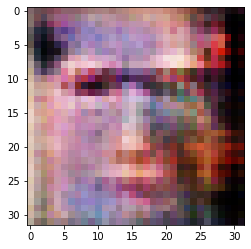

In [43]:
que_se_entreno_m1, prediccion_falsa_m1 = entrenar(gan1, 3000, 150, "resultadosGAN-8")

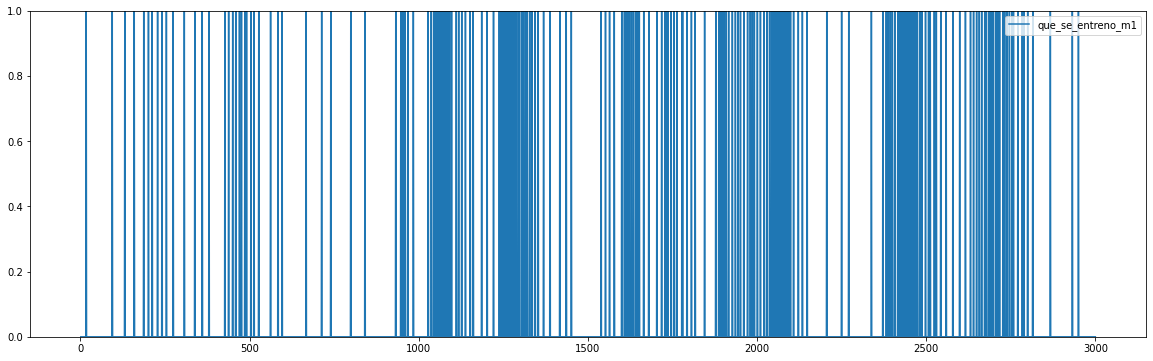

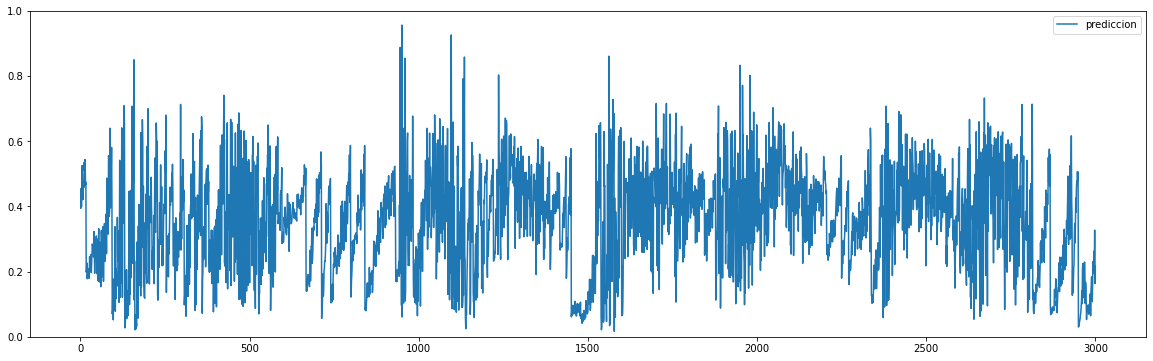

In [44]:
plot_acumulado(len(que_se_entreno_m1), 1, que_se_entreno_m1 = que_se_entreno_m1) #1 para discrimiando, 0 para generador
plot_acumulado(len(prediccion_falsa_m1), 1, prediccion = prediccion_falsa_m1)

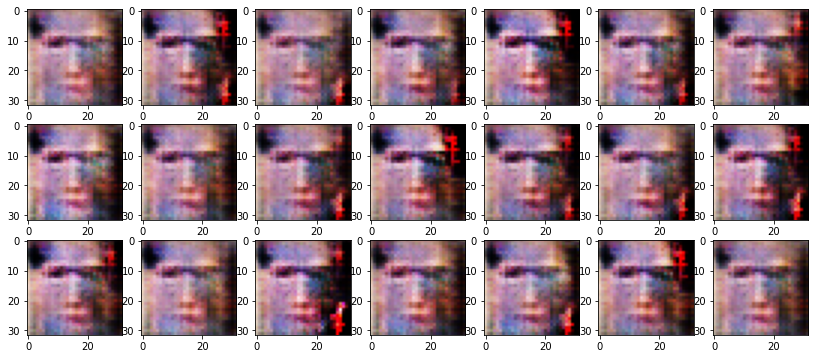

In [46]:
visualizarMosaico(gan1, 3, 7)

No se aprecia mejora en la generacion o en el tiempo y pareciera que es mas propenso al overfitting